# Regressão 4 - Prática

Carregue a base ```prev_renda_II.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média 
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [403]:
# Bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from io import StringIO

In [2]:
# Carregando dados
df = pd.read_csv('prev_renda_II.csv')
print(df.shape)
df.head()

(750000, 14)


data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0  2015-01-01   5762    M                S               N           0   
1  2015-01-01   1279    M                S               N           0   
2  2015-01-01  14111    M                S               N           0   
3  2015-01-01   8189    M                N               S           2   
4  2015-01-01   1830    F                N               S           2   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário    Superior completo       Casado            Casa     47   
1  Assalariado  Superior incompleto       Casado            Casa     30   
2  Assalariado    Superior completo       Casado            Casa     28   
3  Assalariado                Médio       Casado            Casa     44   
4  Assalariado    Superior completo       Casado            Casa     33   

   tempo_emprego  qt_pessoas_residencia     renda  
0      16.717808                    2.0  11138.14  
1       9.600000                    2.0   2424.81  
2       8.208219                    2.0  13749.66  
3       1.301370                    4.0   2361.84  
4       1.254795                    4.0    790.78

In [3]:
# Modificando a data e removendo a variável "index"
df.drop(columns=['index'], inplace=True)
df.data_ref = pd.to_datetime(df.data_ref)

In [4]:
df.dtypes

data_ref                 datetime64[ns]
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
dtype: object

##### Analisando uma descrição básica dos dados 

In [5]:
df.select_dtypes('number').describe().T

count          mean           std        min  \
qtd_filhos             750000.0      0.433267      0.738516   0.000000   
idade                  750000.0     43.796907     11.229454  22.000000   
tempo_emprego          624240.0      7.746165      6.684181   0.117808   
qt_pessoas_residencia  750000.0      2.212315      0.903041   1.000000   
renda                  750000.0  23977.420954  90399.725246  95.300000   

                               25%          50%           75%           max  
qtd_filhos                0.000000     0.000000      1.000000  1.400000e+01  
idade                    34.000000    43.000000     53.000000  6.800000e+01  
tempo_emprego             3.049315     6.046575     10.180822  4.290685e+01  
qt_pessoas_residencia     2.000000     2.000000      3.000000  1.500000e+01  
renda                  3469.370000  7929.980000  18647.160000  6.802261e+06

In [6]:
df.select_dtypes('object').describe().transpose()

count unique          top    freq
sexo              750000      2            F  504418
posse_de_veiculo  750000      2            N  457678
posse_de_imovel   750000      2            S  503485
tipo_renda        750000      5  Assalariado  385926
educacao          750000      5        Médio  447849
estado_civil      750000      5       Casado  526279
tipo_residencia   750000      6         Casa  674054

##### Dados missing

In [7]:
df.isna().sum()

data_ref                      0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [8]:
miss_te = df.tempo_emprego.isna().sum()
total_data = df.shape[0]

# Obtendo a porcentagem de dados faltantes
prop = miss_te / total_data
print(f'--> A porcentagem de dados faltantes é de {prop:.2%}.')

--> A porcentagem de dados faltantes é de 16.77%.


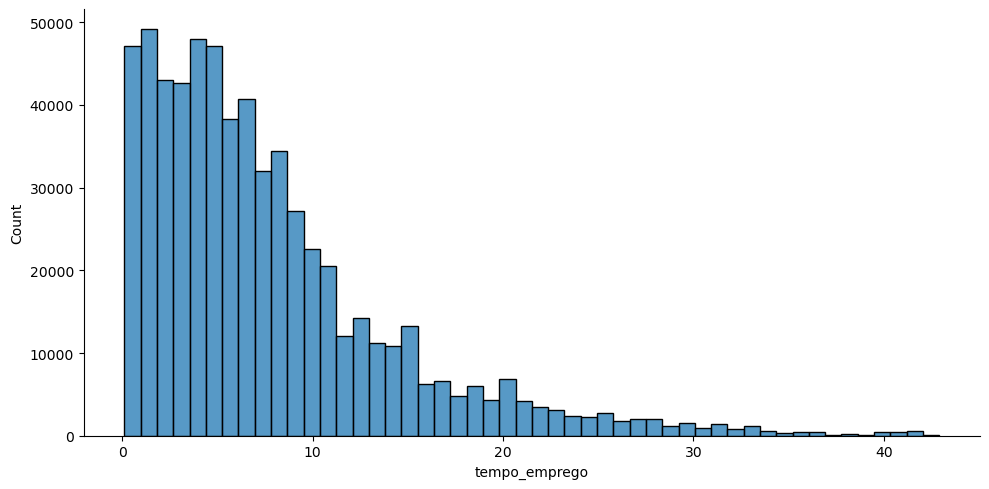

In [9]:
sns.displot(df.tempo_emprego,
            bins = 50, 
            height = 5, 
            aspect = 2);

##### Analisando a distribuição ao considerar a substituição dos dados missing

In [10]:
# média e mediana
df.tempo_emprego.mean(), df.tempo_emprego.median()

(7.746164800507006, 6.046575342465753)

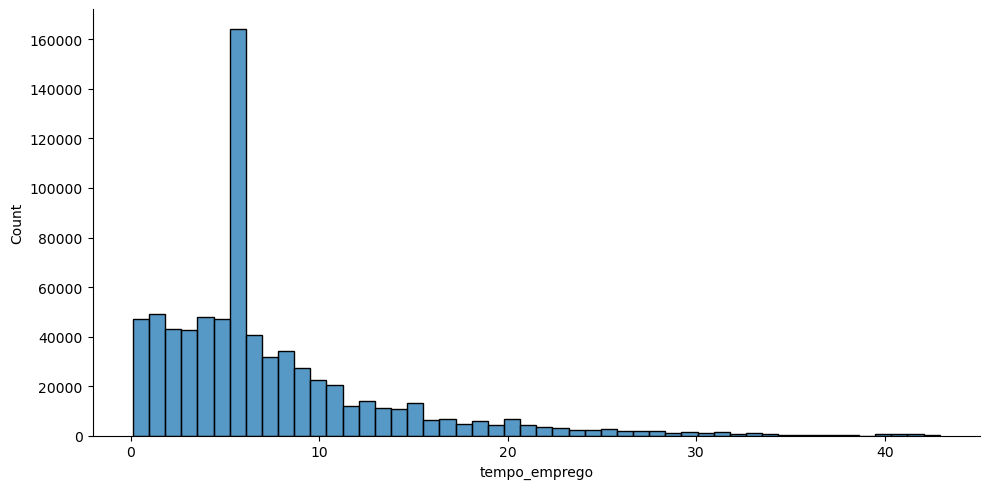

In [11]:
# Substituindo missings pela mediana
df_test = df.copy()
df_test.tempo_emprego = df['tempo_emprego'].fillna(df.tempo_emprego.median())

sns.displot(df_test.tempo_emprego, 
            bins=50, 
            height = 5, 
            aspect = 2);

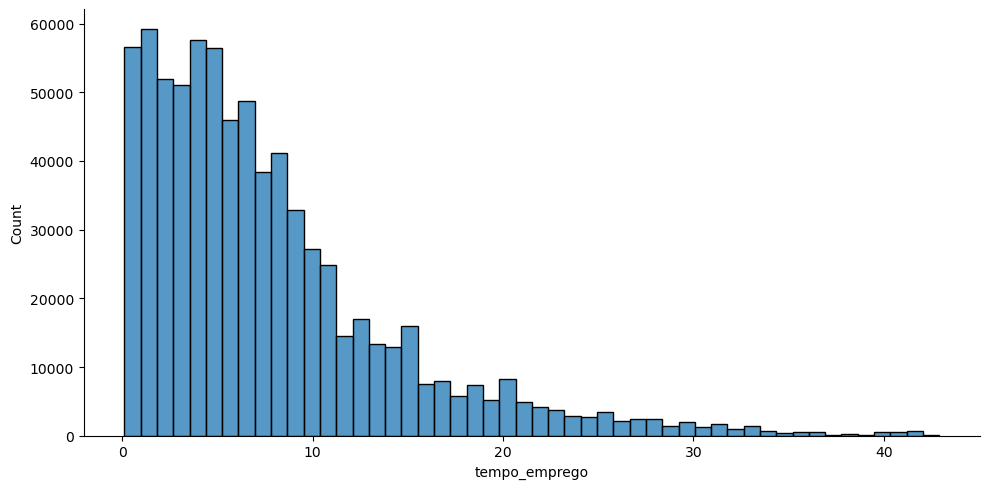

In [12]:
# Substituindo os dados faltantes por dados anteriores preenchidos
df_test2 = df.copy()
df_test2.tempo_emprego = df_test2['tempo_emprego'].ffill()

sns.displot(df_test2.tempo_emprego,
            bins = 50, 
            height = 5, 
            aspect = 2);

> **Como apresentado, há múltiplas formas de tratar dados faltantes, mas aqui iremos optar por remover tais dados (considerando que em práticas anteriores os valores missing foram substituídos pela média), uma vez que não representam uma proporção tão expressiva dos dados.**

In [13]:
# Removendo dados missing

df.dropna(inplace=True)
print(df.isna().sum())
print(df.info())
df.head()

data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 624240 entries, 0 to 749998
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               624240 non-null  datetime64[ns]
 1   sexo                   624240 non-null  object        
 2   posse_de_veiculo       624240 non-null  object        
 3   posse_de_imovel        624240 non-null  object        
 4   qtd_filhos             624240 non-null  int64         
 5   tipo_renda             624240 non-null  object        
 6   educacao               624240 non-null  objec

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0 2015-01-01    M                S               N           0   Empresário   
1 2015-01-01    M                S               N           0  Assalariado   
2 2015-01-01    M                S               N           0  Assalariado   
3 2015-01-01    M                N               S           2  Assalariado   
4 2015-01-01    F                N               S           2  Assalariado   

              educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0    Superior completo       Casado            Casa     47      16.717808   
1  Superior incompleto       Casado            Casa     30       9.600000   
2    Superior completo       Casado            Casa     28       8.208219   
3                Médio       Casado            Casa     44       1.301370   
4    Superior completo       Casado            Casa     33       1.254795   

   qt_pessoas_residencia     renda  
0                    2.0  11138.14  
1                    2.0   2424.81  
2                    2.0  13749.66  
3                    4.0   2361.84  
4                    4.0    790.78

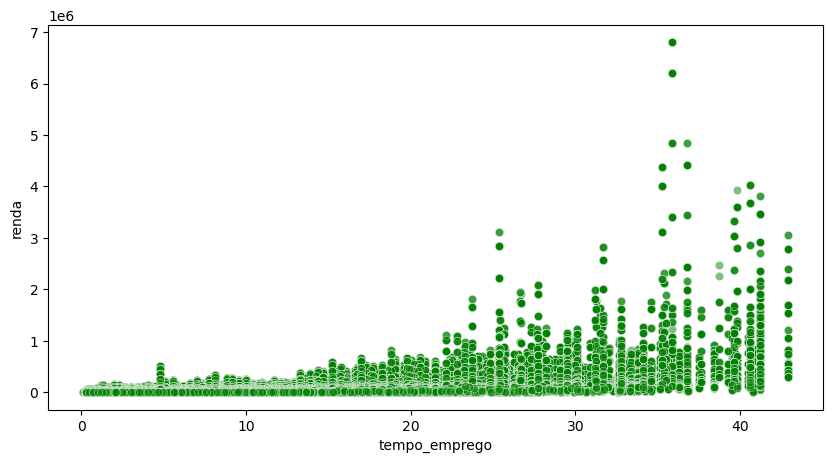

In [14]:
# Analisando a renda (variável resposta) em relação ao tempo_emprego

fig, ax = plt.subplots(figsize=[10,5])
sns.scatterplot(x = 'tempo_emprego', 
                y = 'renda', 
                data = df,
                color = 'green',
                alpha = .5,
                ax = ax);

Como podemos ver, o `tempo_emprego` tem grande influência sobre a renda. Logo, o tratamento dos dados missing deve ser feito com cautela, pois isso poderá influenciar no modelo a ser criado.

##### Separando em dados de treino e teste

Vamos separar os dados em relação às datas, selecionando os três últimos meses como dados de teste (~$25$% dos dados). Aqui destaco que isso nem sempre é uma boa ideia, pode ser interessante também selecionar uma amostra aleatória, pois os dados dos últimos meses podem estar enviesados por algum fator externo que não se faz presente. Mas claro, isso depende do objetivo do estudo em questão.

In [15]:
print(f'A data inicial e final são {df.data_ref.min()} e {df.data_ref.max()}, respectivamente.')

A data inicial e final são 2015-01-01 00:00:00 e 2016-03-01 00:00:00, respectivamente.


In [16]:
df_train = df[df.data_ref <= '2015-12-01']
df_test = df[df.data_ref > '2015-12-01']

print(df_train.shape)
print(df_test.shape)

print(f'--> A porcentagem dos dados separados para teste é de {df_test.shape[0]/df_train.shape[0]:.2%}')

(499269, 13)
(124971, 13)
--> A porcentagem dos dados separados para teste é de 25.03%


##### Rodando um modelo de regressão para os dados tratados

In [17]:
df_dum = pd.get_dummies(df_train.drop(columns=['data_ref']), drop_first=True) 
col_names = [_.replace(' ', '_') for _ in df_dum.columns]
df_dum.columns = col_names
col_names.remove('renda')

# Criando a expressão (aplicando log(renda))
expression = 'np.log(renda) ~ ' + ' + '.join(col_names)
print(expression)

np.log(renda) ~ qtd_filhos + idade + tempo_emprego + qt_pessoas_residencia + sexo_M + posse_de_veiculo_S + posse_de_imovel_S + tipo_renda_Bolsista + tipo_renda_Empresário + tipo_renda_Pensionista + tipo_renda_Servidor_público + educacao_Médio + educacao_Pós_graduação + educacao_Superior_completo + educacao_Superior_incompleto + estado_civil_Separado + estado_civil_Solteiro + estado_civil_União + estado_civil_Viúvo + tipo_residencia_Casa + tipo_residencia_Com_os_pais + tipo_residencia_Comunitário + tipo_residencia_Estúdio + tipo_residencia_Governamental


In [18]:
# Rodando modelo 
reg1 = smf.ols(expression, data = df_dum).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                 1.899e+04
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        08:29:44   Log-Likelihood:            -6.6419e+05
No. Observations:              499269   AIC:                         1.328e+06
Df Residuals:                  499244   BIC:                         1.329e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 7.7588      0.050    155.433      0.000       7.661       7.857
sexo_M[T.True]                            0.1393      0.003     47.423      0.000       0.134       0.145
posse_de_veiculo_S[T.True]                0.0012      0.003      0.437      0.662      -0.004       0.007
posse_de_imovel_S[T.True]                 0.1829      0.003     65.322      0.000       0.177       0.188
tipo_renda_Bolsista[T.True]              -0.2173      0.053     -4.138      0.000      -0.320      -0.114
tipo_renda_Empresário[T.True]             0.1448      0.003     48.280      0.000       0.139       0.151
tipo_renda_Pensionista[T.True]           -0.1274      0.058     -2.180      0.029      -0.242      -0.013
tipo_renda_Servidor_público[T.True]       0.1333      0.004     30.199      0.000       0.125       0.142
educacao_Médio[T.True]                    0.0399      0.015      2.698      0.007       0.011       0.069
educacao_Pós_graduação[T.True]            0.1671      0.039      4.244      0.000       0.090       0.244
educacao_Superior_completo[T.True]        0.1353      0.015      9.107      0.000       0.106       0.164
educacao_Superior_incompleto[T.True]      0.0602      0.016      3.781      0.000       0.029       0.091
estado_civil_Separado[T.True]             0.1164      0.024      4.901      0.000       0.070       0.163
estado_civil_Solteiro[T.True]             0.1173      0.023      5.038      0.000       0.072       0.163
estado_civil_União[T.True]                0.0086      0.005      1.763      0.078      -0.001       0.018
estado_civil_Viúvo[T.True]                0.0928      0.025      3.756      0.000       0.044       0.141
tipo_residencia_Casa[T.True]             -0.1137      0.011    -10.800      0.000      -0.134      -0.093
tipo_residencia_Com_os_pais[T.True]      -0.0804      0.012     -6.787      0.000      -0.104      -0.057
tipo_residencia_Comunitário[T.True]      -0.1643      0.021     -7.921      0.000      -0.205      -0.124
tipo_residencia_Estúdio[T.True]          -0.1804      0.018     -9.949      0.000      -0.216      -0.145
tipo_residencia_Governamental[T.True]    -0.0869      0.013     -6.828      0.000      -0.112      -0.062
qtd_filhos                               -0.0985      0.023     -4.258      0.000      -0.144      -0.053
idade                                     0.0042      0.000     26.118      0.000       0.004       0.005
tempo_emprego                             0.1290      0.000    616.492      0.000       0.129       0.129
qt_pessoas_residencia                     0.1030      0.023      4.460      0.000       0.058       0.148
==============================================================================
Omnibus:                      873.40

In [19]:
# Rodando um modelo simplificado

reg2 = smf.ols("""np.log(renda) ~ tempo_emprego + idade + posse_de_imovel +
                  sexo + tipo_renda""", 
                     data = df_train).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                 5.665e+04
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        08:29:49   Log-Likelihood:            -6.6489e+05
No. Observations:              499269   AIC:                         1.330e+06
Df Residuals:                  499260   BIC:                         1.330e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          7.9688      0.006   1261.133      0.000       7.956       7.981
posse_de_imovel[T.S]               0.1812      0.003     66.231      0.000       0.176       0.187
sexo[T.M]                          0.1353      0.003     49.276      0.000       0.130       0.141
tipo_renda[T.Bolsista]            -0.1532      0.053     -2.916      0.004      -0.256      -0.050
tipo_renda[T.Empresário]           0.1529      0.003     51.296      0.000       0.147       0.159
tipo_renda[T.Pensionista]         -0.0750      0.058     -1.283      0.199      -0.190       0.040
tipo_renda[T.Servidor público]     0.1482      0.004     33.762      0.000       0.140       0.157
tempo_emprego                      0.1290      0.000    616.651      0.000       0.129       0.129
idade                              0.0033      0.000     22.607      0.000       0.003       0.004
==============================================================================
Omnibus:                      831.504   Durbin-Watson:                   1.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              727.852
Skew:                          -0.046   Prob(JB):                    8.89e-159
Kurtosis:                       2.837   Cond. No.                     1.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

##### Verificando a distribuição dos resíduos (é normal?)

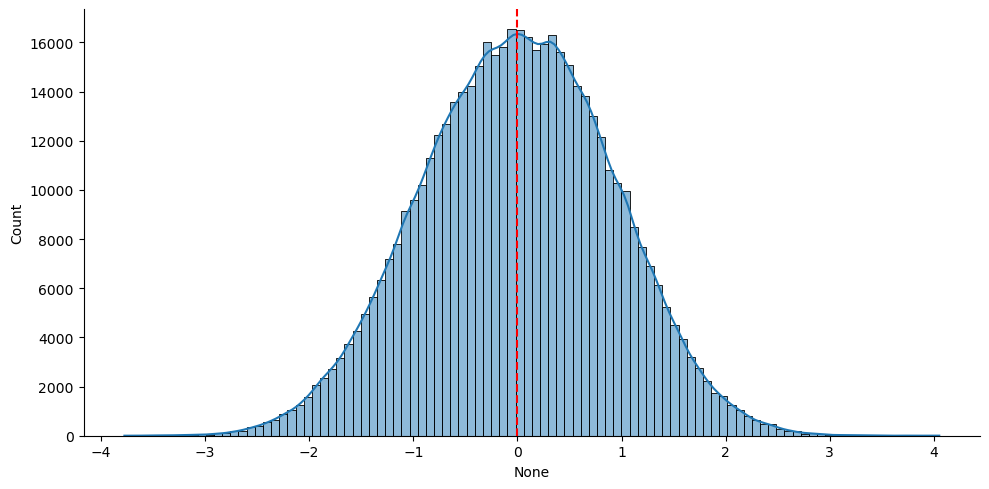

In [20]:
# Distribuição dos resíduos

sns.displot(x = reg1.resid, 
            bins = 100,
            height = 5,
            aspect = 2,
            kde = True
);
plt.axvline(x=0, color='red', ls='--');

Note que a distribuição dos resíduos apresenta um perfil normal (gaussiano).

#### Verificando a independência dos resíduos

In [21]:
# resíduos
residuos1 = reg1.resid

# preditos
preditos1 = reg1.predict()

##### Resíduos em função dos valores preditos

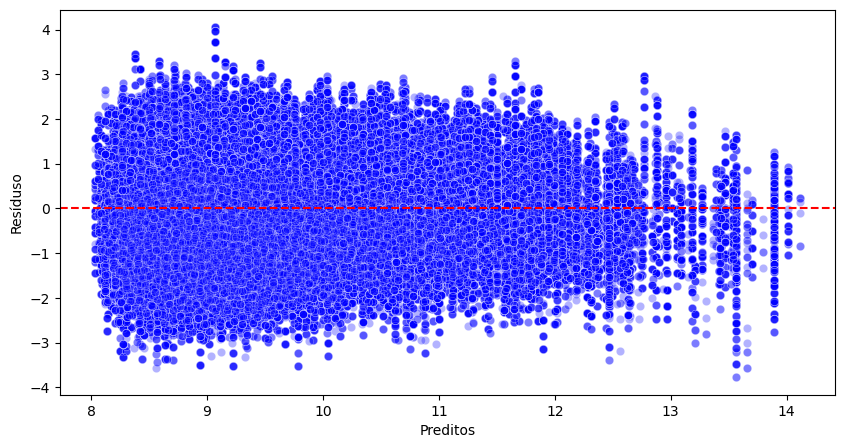

In [22]:
plt.figure(figsize=[10,5])
sns.scatterplot(y = residuos1, 
                x = preditos1, 
                color = 'blue',
                alpha = .3)
plt.axhline(y = 0, color = 'red', ls = '--')
plt.xlabel('Preditos')
plt.ylabel('Resíduso')
plt.show()

##### Avaliando os resíduos em função das variáveis

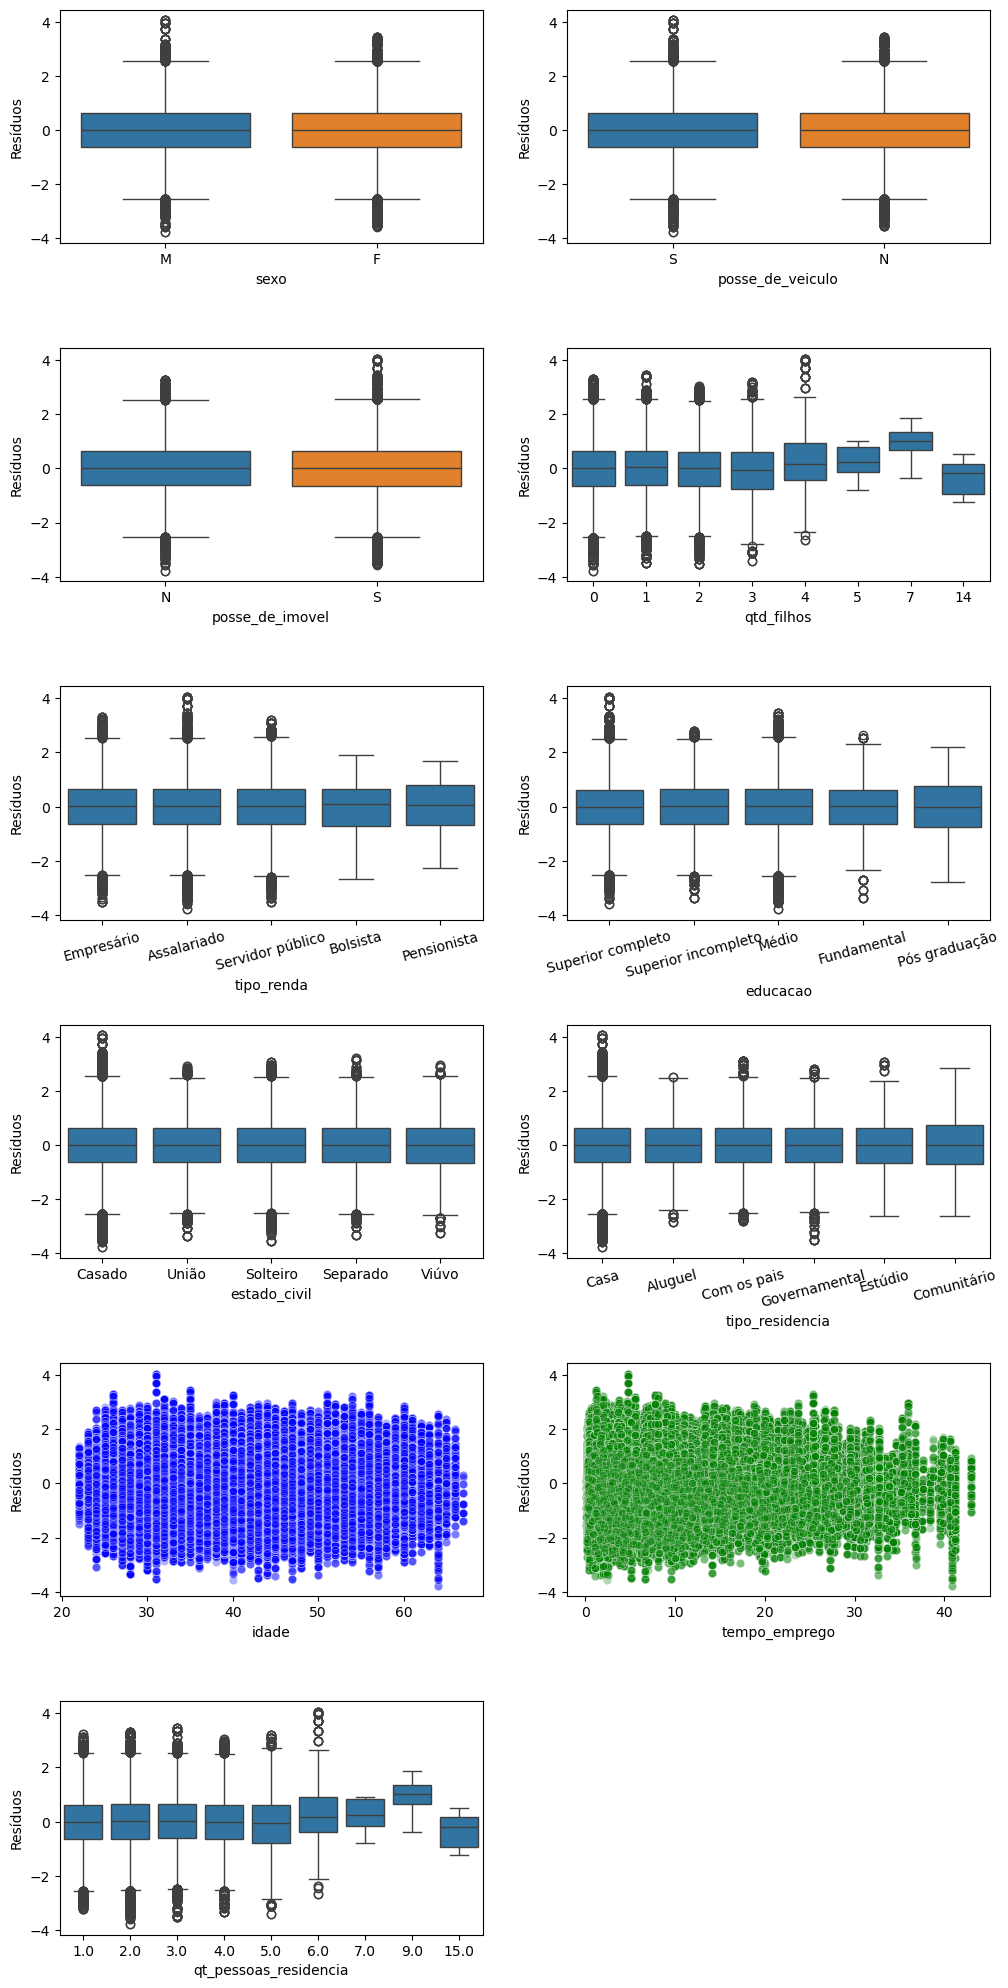

In [23]:
fig, axes = plt.subplots(6, 2, figsize=[12, 25])

# Sexo
sns.boxplot(x = 'sexo', y = residuos1, data = df_train, hue='sexo', ax=axes[0,0])
axes[0,0].set_ylabel('Resíduos')

# posse_de_veiculo
sns.boxplot(data = df_train, x = 'posse_de_veiculo', y = residuos1, 
            hue = 'posse_de_veiculo', ax=axes[0,1])
axes[0,1].set_ylabel('Resíduos')

# posse_de_imovel
sns.boxplot(data = df_train, x = 'posse_de_imovel', y = residuos1, 
            hue = 'posse_de_imovel', ax=axes[1,0])
axes[1,0].set_ylabel('Resíduos')

# qtd_filhos
sns.boxplot(data = df_train, x = 'qtd_filhos', y = residuos1, 
            ax=axes[1,1])
axes[1,1].set_ylabel('Resíduos')

# tipo_renda
sns.boxplot(data = df_train, x = 'tipo_renda', y = residuos1, 
            ax=axes[2,0])
axes[2,0].set_ylabel('Resíduos')
axes[2,0].tick_params('x', rotation=15)

# educacao
sns.boxplot(data = df_train, x = 'educacao', y = residuos1, 
            ax=axes[2,1])
axes[2,1].set_ylabel('Resíduos')
axes[2,1].tick_params('x', rotation=15)

# estado_civil
sns.boxplot(data = df_train, x = 'estado_civil', y = residuos1, 
            ax=axes[3,0])
axes[3,0].set_ylabel('Resíduos')

# tipo_residencia
sns.boxplot(data = df_train, x = 'tipo_residencia', y = residuos1, 
            ax=axes[3,1])
axes[3,1].set_ylabel('Resíduos')
axes[3,1].tick_params('x', rotation=15)

# Idade
sns.scatterplot(data = df_train, x = 'idade', y = residuos1,
               color = 'blue', alpha= .3, ax=axes[4,0])
axes[4,0].set_ylabel('Resíduos')

# tempo_emprego
sns.scatterplot(data = df_train, x = 'tempo_emprego', y = residuos1,
               color = 'green', alpha= .3, ax=axes[4,1])
axes[4,1].set_ylabel('Resíduos')

# qt_pessoas_residencia
sns.boxplot(data = df_train, x = 'qt_pessoas_residencia', y = residuos1,
               ax=axes[5,0])
axes[5,0].set_ylabel('Resíduos')

fig.delaxes(axes[5,1])

plt.subplots_adjust(hspace=.45)
plt.show()

Não há um padrão claro entre os resíduos e as variáveis. Podemos notar que há distorções mais expressivas para variáveis como `qt_pessoas_residencia` e `qtd_filhos`, isso parece ocorrer em relação aos dados ou valores que possuem pouca ocorrência, ou seja, valores menos frequentes. 

Veja a saída da célula abaixo. Os três últimos valores (index) são rarefeitos se comparados aos demais.

In [24]:
print('--> Para a variável "qtd_filhos"', df_train.qtd_filhos.value_counts().sort_index(), '\n')
print('--> Para a variável "qt_pessoas_residencia"', df_train.qt_pessoas_residencia.value_counts().sort_index())

--> Para a variável "qtd_filhos" qtd_filhos
0     316412
1     120029
2      54919
3       6837
4        853
5         78
7         74
14        67
Name: count, dtype: int64 

--> Para a variável "qt_pessoas_residencia" qt_pessoas_residencia
1.0      79291
2.0     258023
3.0     101681
4.0      52627
5.0       6575
6.0        886
7.0         45
9.0         74
15.0        67
Name: count, dtype: int64


##### Será que há uma relação entre o valor médio dos resíduos e o mês de referência?


In [25]:
df_month = df_train.copy()
df_month.data_ref = df_month.data_ref.dt.to_period('M')
df_month.tail(2)

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
599998  2015-12    F                S               S           1   
599999  2015-12    F                S               S           1   

              tipo_renda           educacao estado_civil tipo_residencia  \
599998        Empresário  Superior completo     Solteiro            Casa   
599999  Servidor público  Superior completo        Viúvo            Casa   

        idade  tempo_emprego  qt_pessoas_residencia     renda  
599998     27       6.791781                    2.0  20449.25  
599999     49       1.164384                    2.0   1935.87

data_ref
2015-01   -0.963890
2015-02   -0.672267
2015-03   -0.324347
2015-04    0.062052
2015-05    0.409237
2015-06    0.664283
2015-07    0.749403
2015-08    0.660558
2015-09    0.391607
2015-10    0.047679
2015-11   -0.336246
2015-12   -0.681008
Freq: M, Name: residuo, dtype: float64


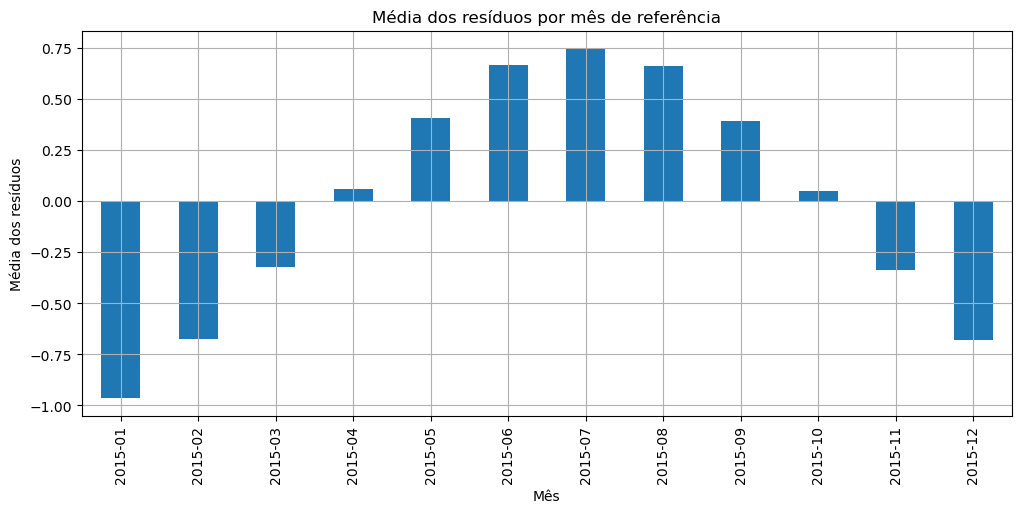

In [26]:
# Valor médio dos resíduos em relação aos meses

df_month['residuo'] = reg1.resid
media_residuo = df_month.groupby('data_ref')['residuo'].mean()
print(media_residuo)

# Plot
plt.figure(figsize=[12,5])
media_residuo.plot.bar()
plt.title('Média dos resíduos por mês de referência')
plt.ylabel('Média dos resíduos')
plt.xlabel('Mês')
plt.grid()
plt.show()

O valor médio dos resíduos é uma função do mês de referência e, para os dados analisados, oscila em torno de zero.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

> **Utilizaremos algumas técnicas para avaliar os dados, uma vez que temos muitos dados e não muito poder de processamento**

#### 1 - Para uma primeira avaliação, façamos uma categorização na variável `tempo_emprego`

In [27]:
df_train_cat = df_train.copy()

In [28]:
df_train['tempo_emprego_cat'] = pd.qcut(df_train.tempo_emprego, 50, duplicates='drop')

tabela = pd.DataFrame()
tabela['contagem'] = df_train.tempo_emprego_cat.value_counts()
tabela['renda_media'] = df_train.groupby('tempo_emprego_cat', observed=False)['renda'].mean()
tabela['renda_media_log'] = np.log(tabela.renda_media)
tabela['tempo_emprego_media'] = df_train.groupby('tempo_emprego_cat', observed=False)['tempo_emprego'].mean()
tabela.sort_index(inplace=True)

tabela.reset_index(inplace=True)
tabela.head()

C:\Users\ze\AppData\Local\Temp\ipykernel_13624\4083461569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tempo_emprego_cat'] = pd.qcut(df_train.tempo_emprego, 50, duplicates='drop')


tempo_emprego_cat  contagem  renda_media  renda_media_log  \
0  (0.11699999999999999, 0.425]     10027  6186.751849         8.730165   
1                (0.425, 0.605]     10166  6493.256764         8.778519   
2                (0.605, 0.808]      9772  6512.536367         8.781484   
3                (0.808, 1.033]     10133  7119.096628         8.870536   
4                (1.033, 1.195]     10094  7382.042454         8.906806   

   tempo_emprego_media  
0             0.318733  
1             0.518740  
2             0.704328  
3             0.919089  
4             1.122616

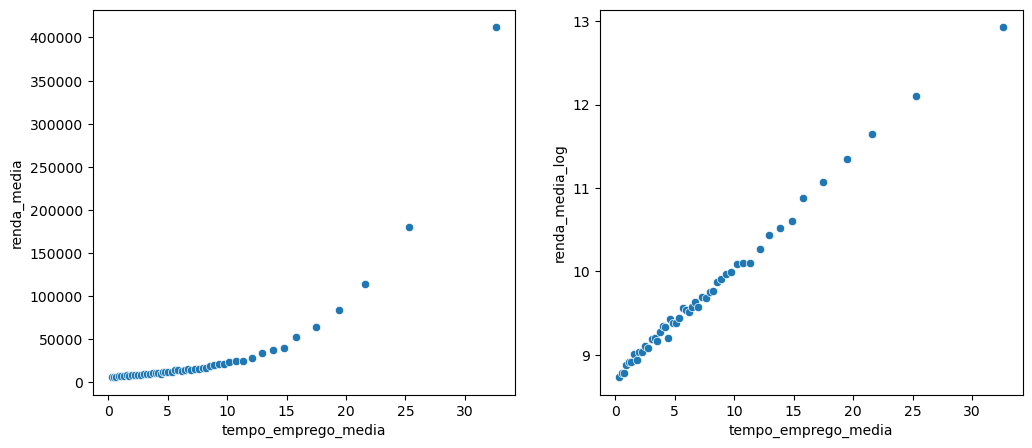

In [29]:
# Verificando os dados obtidos
fig, ax = plt.subplots(1, 2, figsize=[12,5])
sns.scatterplot(data=tabela, x='tempo_emprego_media', y='renda_media', ax=ax[0])
sns.scatterplot(data=tabela, x='tempo_emprego_media', y='renda_media_log', ax=ax[1])
plt.show()

In [30]:
# Gerando um modelo de regressão com base nos novos dados
reg_tab = smf.ols('renda_media_log ~ tempo_emprego_media', data=tabela).fit()
reg_tab.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        renda_media_log   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.463e+04
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           2.56e-61
Time:                        08:30:07   Log-Likelihood:                 78.922
No. Observations:                  50   AIC:                            -153.8
Df Residuals:                      48   BIC:                            -150.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.7364      0.011    790.455      0.000       8.714       8.759
tempo_emprego_media     0.1308      0.001    120.966      0.000       0.129       0.133
==============================================================================
Omnibus:                        0.913   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.633   Jarque-Bera (JB):                0.934
Skew:                          -0.180   Prob(JB):                        0.627
Kurtosis:                       2.436   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

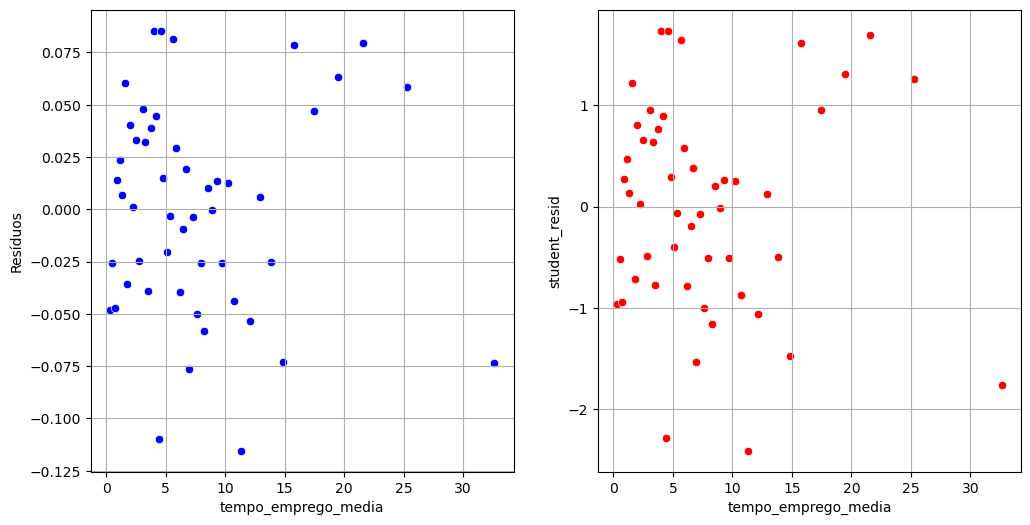

In [31]:
# Visualizando a dispersão dos resíduos
fig, ax = plt.subplots(1, 2, figsize=[12, 6])

sns.scatterplot(x=tabela['tempo_emprego_media'], y=reg_tab.resid, color='blue', ax=ax[0])
ax[0].set_ylabel('Resíduos')
ax[0].grid()

res_st = reg_tab.outlier_test()
sns.scatterplot(x=tabela['tempo_emprego_media'], y=res_st.student_resid, color='red', ax=ax[1])
ax[1].grid()
plt.show()

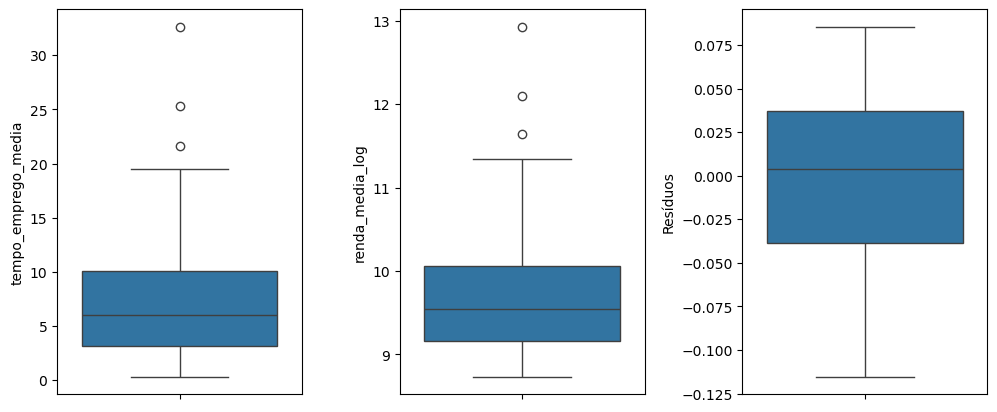

In [32]:
# Verificando a distribuição das variáveis (novas) e dos resíduos

fig, ax = plt.subplots(1, 3, figsize=[12,5])

sns.boxplot(tabela, y = 'tempo_emprego_media', ax=ax[0])
sns.boxplot(tabela, y = 'renda_media_log', ax=ax[1])
sns.boxplot(y=reg_tab.resid, ax=ax[2])
ax[2].set_ylabel('Resíduos')

plt.subplots_adjust(wspace=.4)

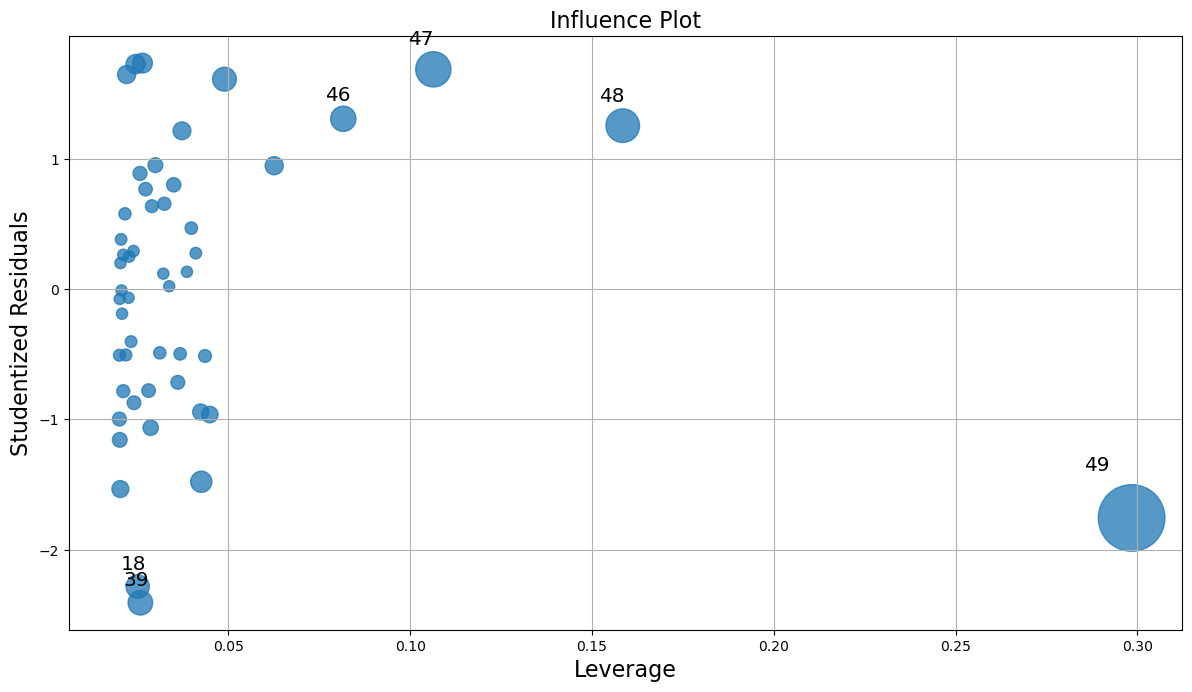

In [33]:
# Verificando pontos influentes

fig, ax = plt.subplots(figsize=[12,7])
fig = sm.graphics.influence_plot(reg_tab, criterion = 'cook', ax=ax)
fig.tight_layout(pad=1.0)
ax.grid()

De acordo com o gráfico de pontos de influência, os elementos de índice `49`, `48`, `47` e `46` são os mais discrepantes e desempenham grande papel na alteração do modelo. 

Faremos a remoção de tal ponto e geração de um novo modelo

In [34]:
tabela2 = tabela.reset_index().drop(index=[49, 48, 47, 46])
reg_tab2 = smf.ols('renda_media_log ~ tempo_emprego_media', data=tabela2).fit()
reg_tab2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        renda_media_log   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     6171.
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           6.03e-49
Time:                        08:30:07   Log-Likelihood:                 74.996
No. Observations:                  46   AIC:                            -146.0
Df Residuals:                      44   BIC:                            -142.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.7426      0.013    695.897      0.000       8.717       8.768
tempo_emprego_media     0.1293      0.002     78.553      0.000       0.126       0.133
==============================================================================
Omnibus:                        0.071   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.207
Skew:                          -0.083   Prob(JB):                        0.902
Kurtosis:                       2.716   Cond. No.                         13.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

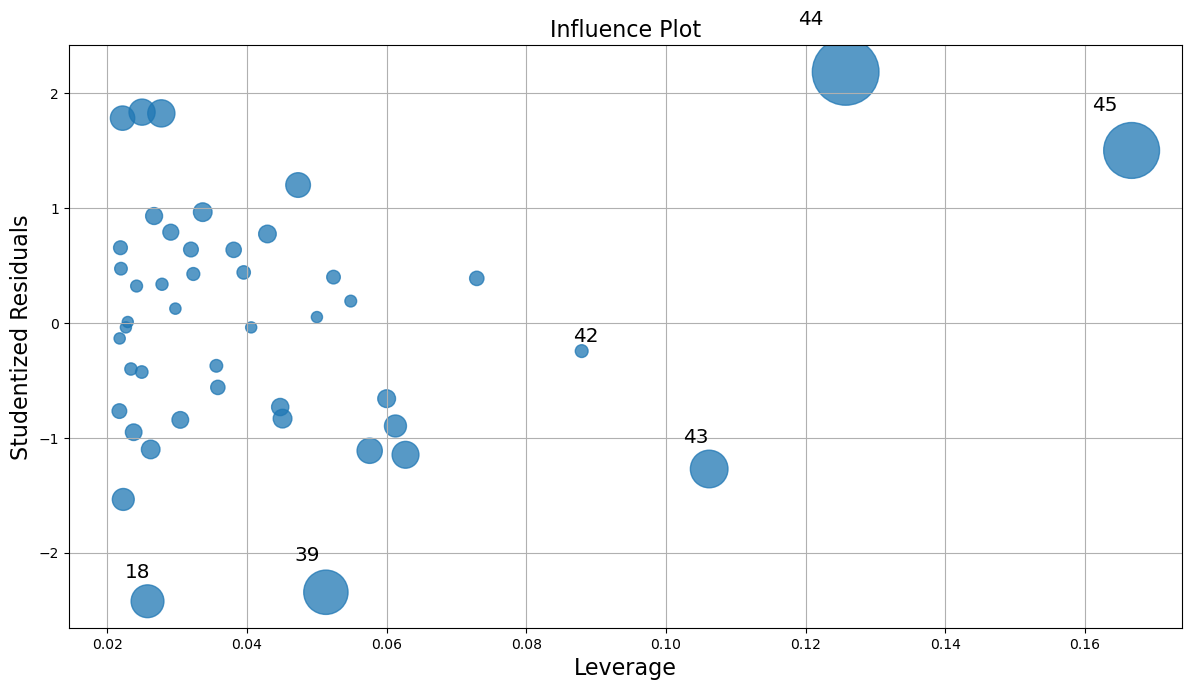

In [35]:
fig, ax = plt.subplots(figsize=[12,7])
fig = sm.graphics.influence_plot(reg_tab2, criterion = 'cook', ax=ax)
fig.tight_layout(pad=1.0)
ax.grid()

Sendo assim, o modelo passa a possuir uma boa legibilidade e um excelente valor de R-quadrado. Vale destacar que isso se aplica aos dados mapeados pelas categorias e que aqui utilizamos apenas a variável explicativa `tempo_emprego`.

No próximo passo iremos selecionar uma "fatia", uma amostra, dos dados brutos e iremos avaliar o modelo com o máximo de variáveis explicativas possível.


#### 2 - Avaliando uma amostra dos dados "brutos" (sample)

Vamos extrair uma amostra dos dados originais (df_train)

In [36]:
df_sample = df_train.sample(1000, random_state = 1994)
df_sample.drop(columns=['tempo_emprego_cat'], inplace=True)
df_sample.head(2)

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
535806 2015-11-01    F                N               S           1   
19072  2015-01-01    F                N               S           1   

         tipo_renda educacao estado_civil tipo_residencia  idade  \
535806   Empresário    Médio     Separado   Governamental     51   
19072   Assalariado    Médio       Casado            Casa     37   

        tempo_emprego  qt_pessoas_residencia    renda  
535806       5.046575                    2.0  5338.67  
19072        6.052055                    3.0  3969.40

In [37]:
prop = (df_sample.shape[0]/df_train.shape[0])
print(f'--> A proporção dos dados selecionados é de {prop:.2%}.')

--> A proporção dos dados selecionados é de 0.20%.


In [38]:
# Modelo de regressão
reg_sample = smf.ols("""np.log(renda) ~ sexo + posse_de_veiculo + posse_de_imovel 
                        + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia 
                        + idade + tempo_emprego + qt_pessoas_residencia""", 
                     data=df_sample).fit()
reg_sample.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     49.61
Date:                Thu, 12 Jun 2025   Prob (F-statistic):          6.08e-138
Time:                        08:30:08   Log-Likelihood:                -1305.8
No. Observations:                1000   AIC:                             2656.
Df Residuals:                     978   BIC:                             2764.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            4.3596      0.267     16.300      0.000       3.835       4.884
sexo[T.M]                            0.1713      0.064      2.661      0.008       0.045       0.298
posse_de_veiculo[T.S]                0.0172      0.062      0.276      0.783      -0.105       0.139
posse_de_imovel[T.S]                 0.0186      0.061      0.304      0.761      -0.101       0.138
tipo_renda[T.Empresário]             0.1704      0.067      2.548      0.011       0.039       0.302
tipo_renda[T.Servidor público]       0.1797      0.098      1.829      0.068      -0.013       0.372
educacao[T.Médio]                   -0.1269      0.374     -0.340      0.734      -0.860       0.607
educacao[T.Pós graduação]            0.5517      0.742      0.744      0.457      -0.904       2.007
educacao[T.Superior completo]       -0.0763      0.375     -0.203      0.839      -0.812       0.660
educacao[T.Superior incompleto]     -0.0125      0.396     -0.031      0.975      -0.790       0.765
estado_civil[T.Separado]             1.7994      0.157     11.475      0.000       1.492       2.107
estado_civil[T.Solteiro]             1.9194      0.129     14.926      0.000       1.667       2.172
estado_civil[T.União]               -0.0458      0.109     -0.419      0.675      -0.260       0.169
estado_civil[T.Viúvo]                1.6785      0.203      8.261      0.000       1.280       2.077
tipo_residencia[T.Casa]              0.2798      0.245      1.141      0.254      -0.201       0.761
tipo_residencia[T.Com os pais]       0.1932      0.272      0.711      0.477      -0.340       0.726
tipo_residencia[T.Comunitário]       0.6587      0.580      1.136      0.256      -0.480       1.797
tipo_residencia[T.Estúdio]           0.4034      0.379      1.063      0.288      -0.341       1.148
tipo_residencia[T.Governamental]     0.3510      0.307      1.144      0.253      -0.251       0.953
qtd_filhos                          -1.6509      0.123    -13.384      0.000      -1.893      -1.409
idade                                0.0061      0.004      1.629      0.104      -0.001       0.013
tempo_emprego                        0.1349      0.005     28.420      0.000       0.126       0.144
qt_pessoas_residencia                1.6711      0.110     15.257      0.000       1.456       1.886
==============================================================================
Omnibus:                        0.278   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.363
Skew:                          -0.017   Prob(JB):                        0.834
Kurtosis:                       2.913   Cond. No.                     1.19e+16
==============================================================

In [39]:
# Obtendo o resíduo de Student (processo pode demorar, isso justifica a amostragem)
st = reg_sample.outlier_test()
res_student = st.student_resid

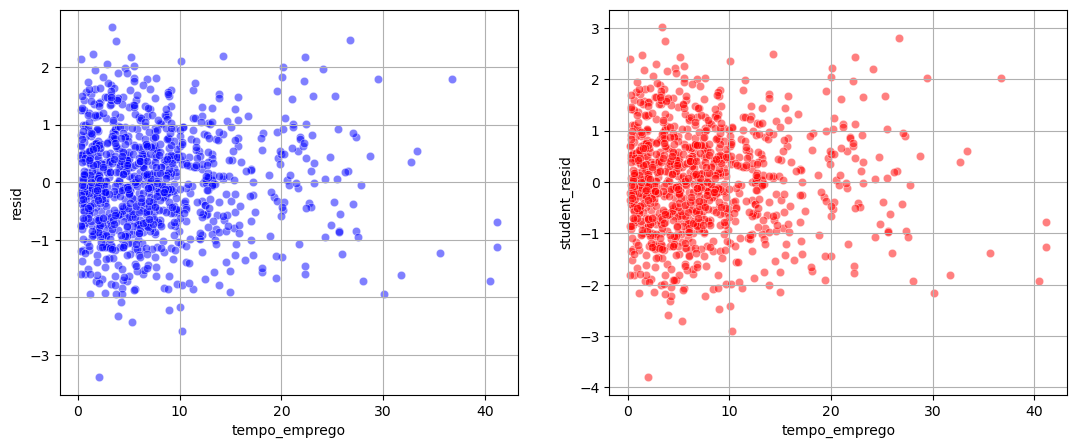

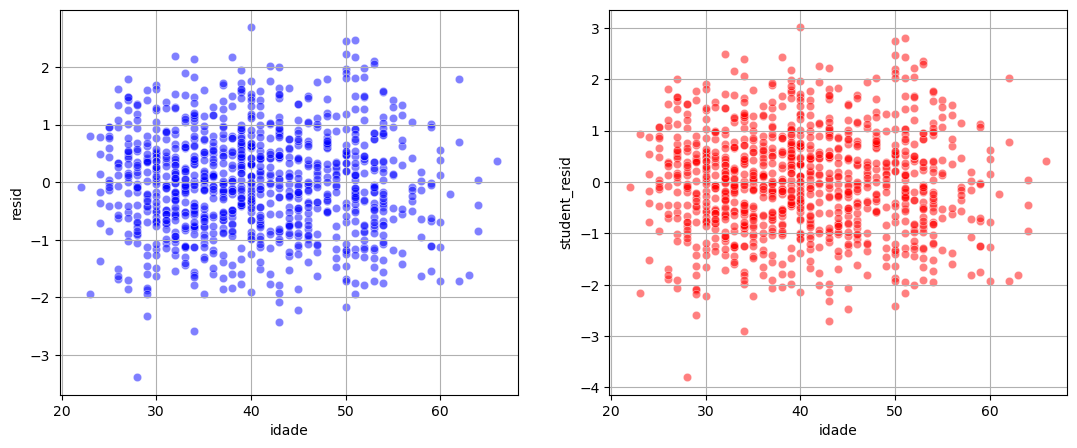

In [40]:
# Gráfico de resíduos e resíduos studentizados em função das variáveis (scatterplot)

vars = ['tempo_emprego', 'idade']

for var in vars:
    fig, ax = plt.subplots(1,2, figsize=[13, 5])
    
    sns.scatterplot(x=var, y=reg_sample.resid, 
                    data=df_sample, color='blue', 
                    alpha=.5, ax=ax[0])
    ax[0].set_ylabel('resid')
    ax[0].grid()
    sns.scatterplot(x=var, y=res_student, 
                    data=df_sample, color='red', 
                    alpha=.5, ax=ax[1])
    ax[1].grid()
    plt.show()

De acordo com os `scatterplots`, podemos notar que há uma distribuição quase homogênea dos resíduos em torno de zero, possuindo apenas alguns pontos que se destacam por sua distância desse valor, tais pontos são possivelmente outliers.

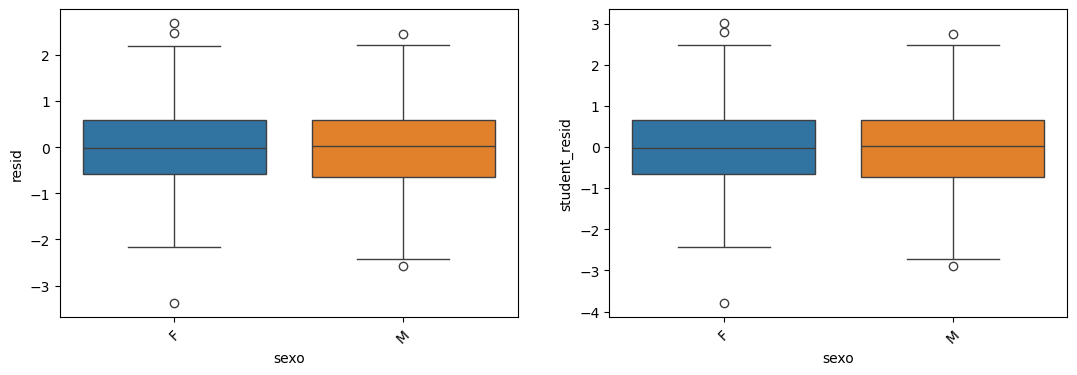

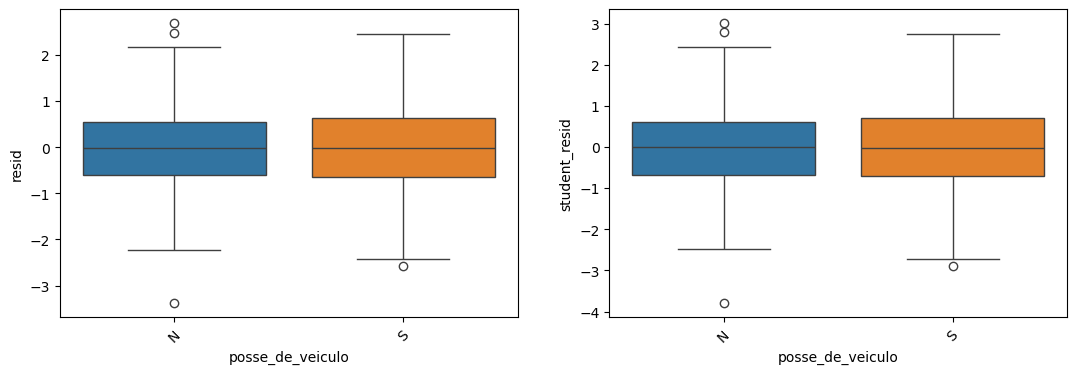

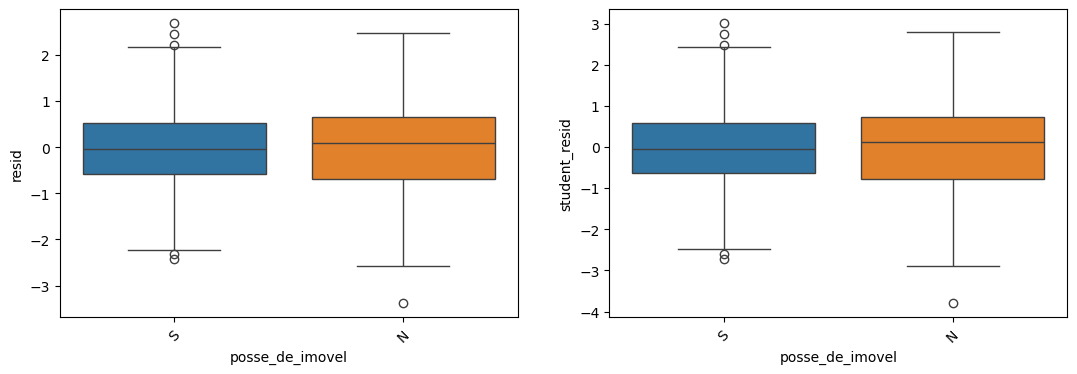

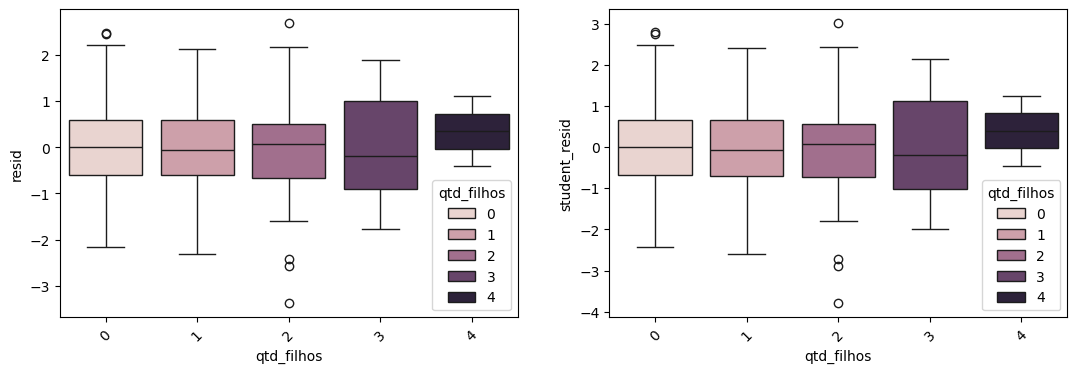

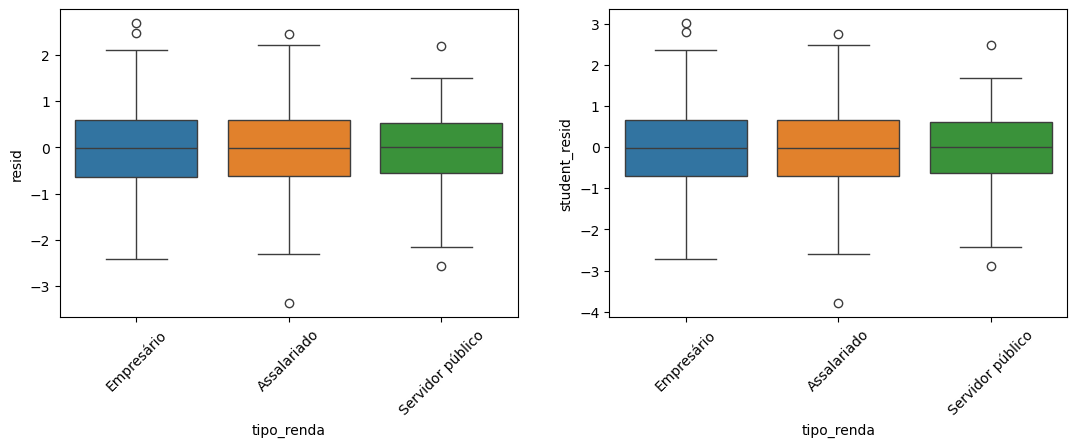

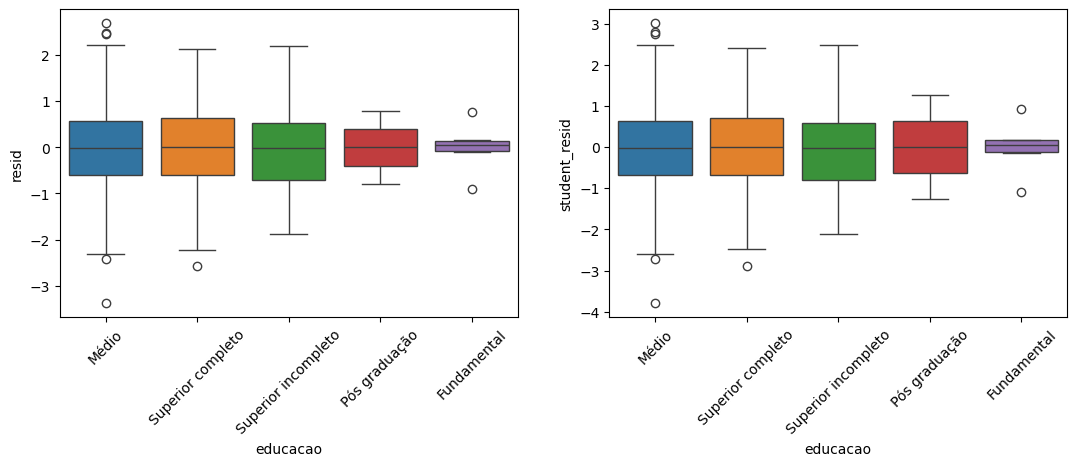

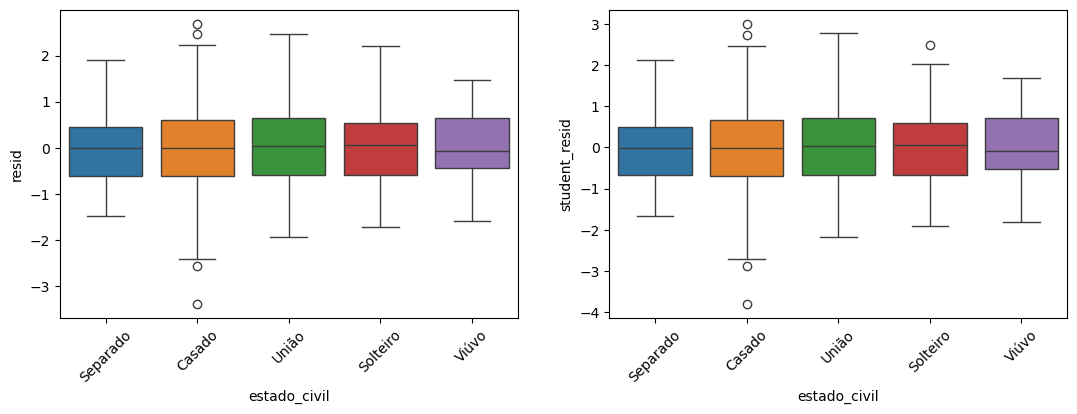

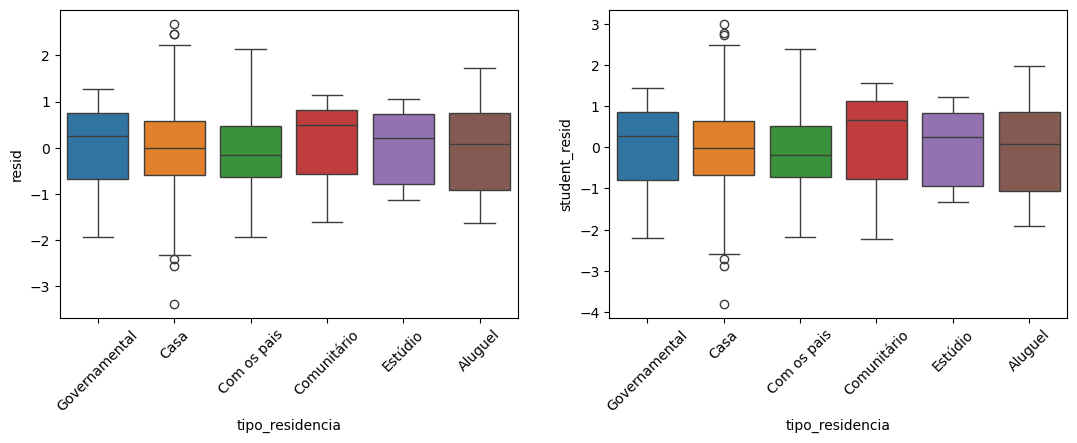

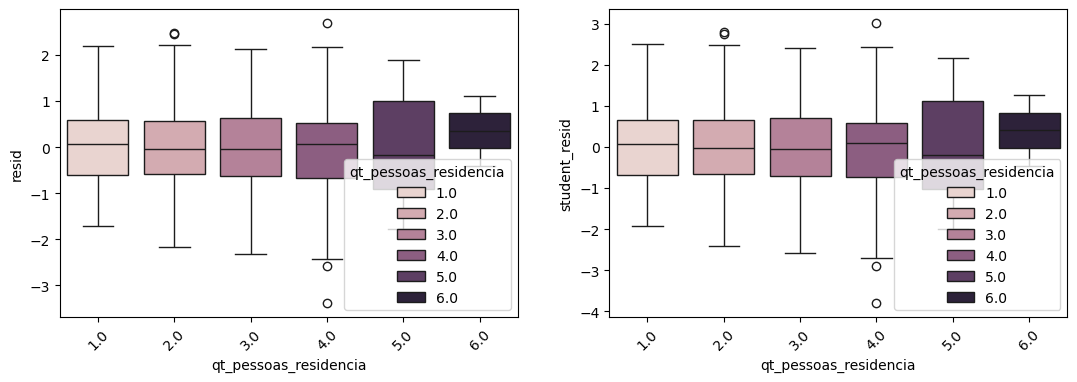

In [41]:
# Gráfico de resíduos e resíduos studentizados em função das variáveis (boxplot)

vars = [ 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 
       'qt_pessoas_residencia']

for var in vars:
    fig, ax = plt.subplots(1,2, figsize=[13, 4])
    
    sns.boxplot(data = df_sample, x = var, y = reg_sample.resid, hue = var, ax=ax[0])
    ax[0].set_ylabel('resid')
    ax[0].tick_params('x', rotation=45)
    
    sns.boxplot(data = df_sample, x = var, y = res_student, hue = var, ax=ax[1])
    ax[1].tick_params('x', rotation=45)
    
    plt.show()  

De acordo com os `boxplots` os resíduos possuem uma boa distribuição. Apenas algumas variáveis que possuem valores com menor incidência aparentam distribuição dos resíduos distorcida (algumas subcategorias nem aparecem na amostragem), como é o caso das variáveis `qt_pessoas_residencia` e `qtd_filhos`.

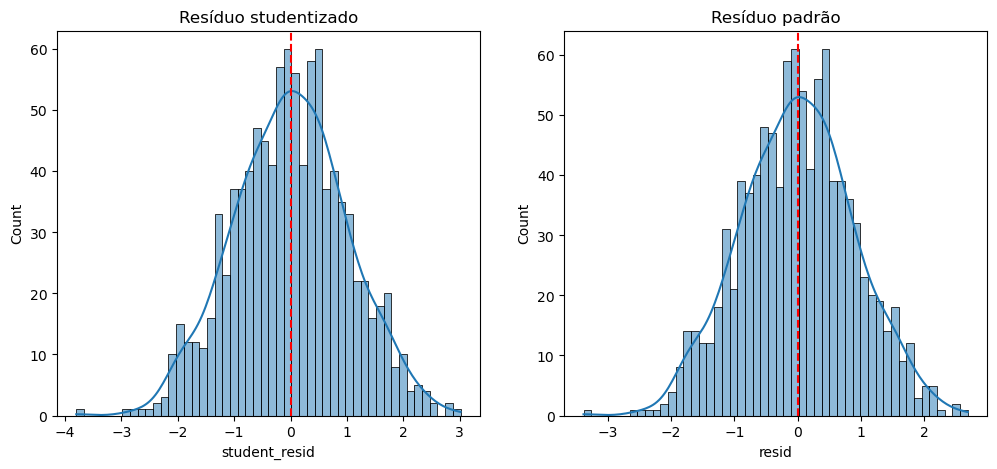

In [42]:
# Avaliando a distribuição dos resíduos

fig, ax = plt.subplots(1,2, figsize=[12, 5])
sns.histplot(x = res_student, kde=True, ax=ax[0], bins=50)
ax[0].axvline(x=0, color='red', ls='--')
ax[0].set_title('Resíduo studentizado')

sns.histplot(x = reg_sample.resid, kde=True, ax=ax[1], bins=50)
ax[1].axvline(x=0, color='red', ls='--')
ax[1].set_title('Resíduo padrão')

ax[1].set_xlabel('resid');

Nota-se que os resíduos possuem um perfil de distribuição normal. 

##### Façamos agora a avalição dos pontos influentes.

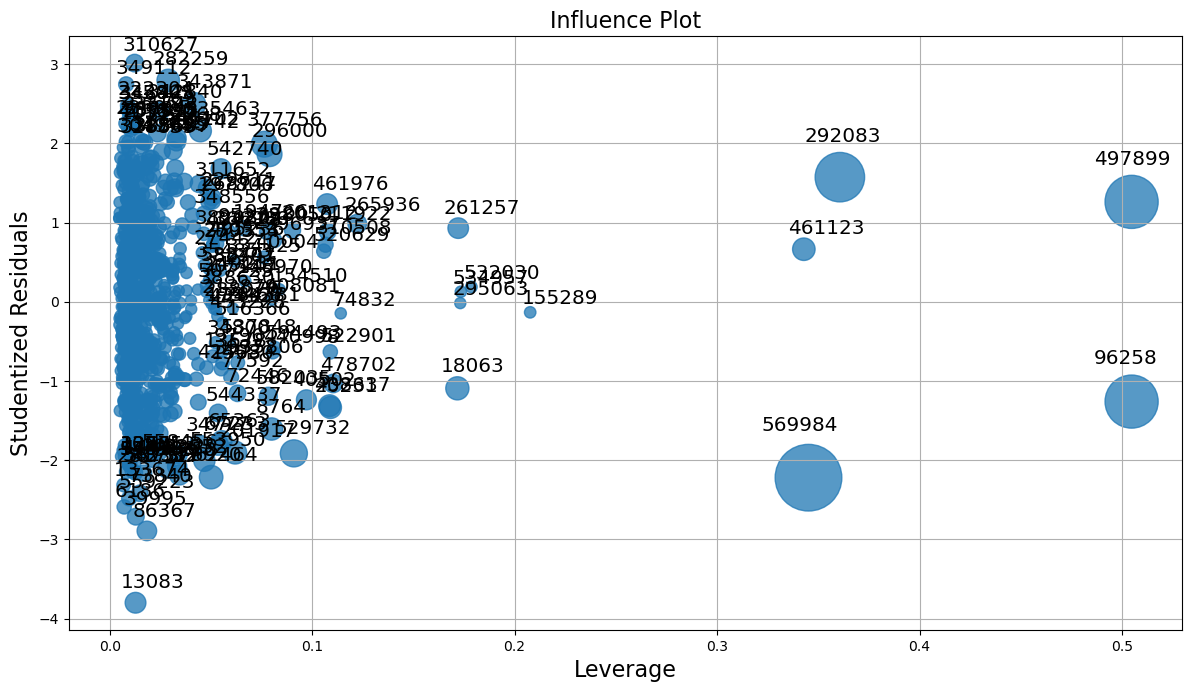

In [43]:
fig, ax = plt.subplots(figsize=[12,7])
fig = sm.graphics.influence_plot(reg_sample, criterion = 'cook', ax=ax)
fig.tight_layout(pad=1.0)
ax.grid()

In [44]:
# Avaliando os dois pontos mais influentes 
df_sample[df_sample.index == 497899]

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
497899 2015-10-01    F                N               S           1   

         tipo_renda       educacao estado_civil tipo_residencia  idade  \
497899  Assalariado  Pós graduação     Solteiro            Casa     34   

        tempo_emprego  qt_pessoas_residencia    renda  
497899       7.586301                    2.0  51605.3

In [45]:
df_sample[df_sample.index == 96258]

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
96258 2015-02-01    F                S               S           1   

       tipo_renda       educacao estado_civil tipo_residencia  idade  \
96258  Empresário  Pós graduação       Casado            Casa     33   

       tempo_emprego  qt_pessoas_residencia    renda  
96258       2.682192                    3.0  5020.34

In [46]:
df_sample[df_sample.index == 569984]

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
569984 2015-12-01    M                S               S           0   

         tipo_renda educacao estado_civil tipo_residencia  idade  \
569984  Assalariado    Médio       Casado     Comunitário     30   

        tempo_emprego  qt_pessoas_residencia    renda  
569984       7.624658                    2.0  3076.15

In [47]:
df_sample[df_sample.index == 292083]

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
292083 2015-06-01    F                N               N           0   

         tipo_renda educacao estado_civil tipo_residencia  idade  \
292083  Assalariado    Médio        Viúvo     Comunitário     54   

        tempo_emprego  qt_pessoas_residencia     renda  
292083            1.6                    1.0  20330.09

In [48]:
df_sample[df_sample.index == 461123]

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
461123 2015-10-01    F                S               N           0   

         tipo_renda           educacao estado_civil tipo_residencia  idade  \
461123  Assalariado  Superior completo       Casado     Comunitário     35   

        tempo_emprego  qt_pessoas_residencia     renda  
461123       6.263014                    2.0  18856.96

In [49]:
df_sample[df_sample.index == 155289]

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
155289 2015-04-01    F                N               S           0   

              tipo_renda     educacao estado_civil tipo_residencia  idade  \
155289  Servidor público  Fundamental        Viúvo            Casa     51   

        tempo_emprego  qt_pessoas_residencia     renda  
155289        7.10411                    1.0  11476.28

In [50]:
# Pontos influentes

lista_pontos_inf = [497899, 96258, 569984, 292083, 461123, 155289, 261257, 532030, 534957, 295063, 18063]

In [51]:
# removendo tais dados e refazendo o modelo
df_sample.drop(index=lista_pontos_inf, inplace=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     57.67
Date:                Thu, 12 Jun 2025   Prob (F-statistic):          2.28e-139
Time:                        08:30:15   Log-Likelihood:                -1292.6
No. Observations:                 989   AIC:                             2623.
Df Residuals:                     970   BIC:                             2716.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            4.2870      0.174     24.621      0.000       3.945       4.629
sexo[T.M]                            0.1761      0.065      2.722      0.007       0.049       0.303
posse_de_veiculo[T.S]                0.0217      0.062      0.347      0.729      -0.101       0.144
posse_de_imovel[T.S]                 0.0318      0.061      0.519      0.604      -0.089       0.152
tipo_renda[T.Empresário]             0.1757      0.067      2.624      0.009       0.044       0.307
tipo_renda[T.Servidor público]       0.1854      0.099      1.880      0.060      -0.008       0.379
educacao[T.Superior completo]        0.0471      0.062      0.757      0.449      -0.075       0.169
educacao[T.Superior incompleto]      0.1099      0.141      0.779      0.436      -0.167       0.387
estado_civil[T.Separado]             1.7835      0.131     13.566      0.000       1.526       2.041
estado_civil[T.Solteiro]             1.8909      0.097     19.550      0.000       1.701       2.081
estado_civil[T.União]               -0.0475      0.109     -0.435      0.663      -0.262       0.167
estado_civil[T.Viúvo]                1.6073      0.198      8.125      0.000       1.219       1.995
tipo_residencia[T.Casa]              0.2738      0.245      1.117      0.264      -0.207       0.755
tipo_residencia[T.Com os pais]       0.1873      0.272      0.690      0.491      -0.346       0.720
tipo_residencia[T.Estúdio]           0.3940      0.379      1.039      0.299      -0.350       1.138
tipo_residencia[T.Governamental]     0.3466      0.307      1.130      0.259      -0.255       0.949
qtd_filhos                          -1.6383      0.089    -18.324      0.000      -1.814      -1.463
idade                                0.0055      0.004      1.461      0.144      -0.002       0.013
tempo_emprego                        0.1352      0.005     28.401      0.000       0.126       0.145
qt_pessoas_residencia                1.6541      0.072     23.100      0.000       1.514       1.795
==============================================================================
Omnibus:                        0.251   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.882   Jarque-Bera (JB):                0.338
Skew:                          -0.010   Prob(JB):                        0.845
Kurtosis:                       2.912   Cond. No.                     1.11e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.43e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

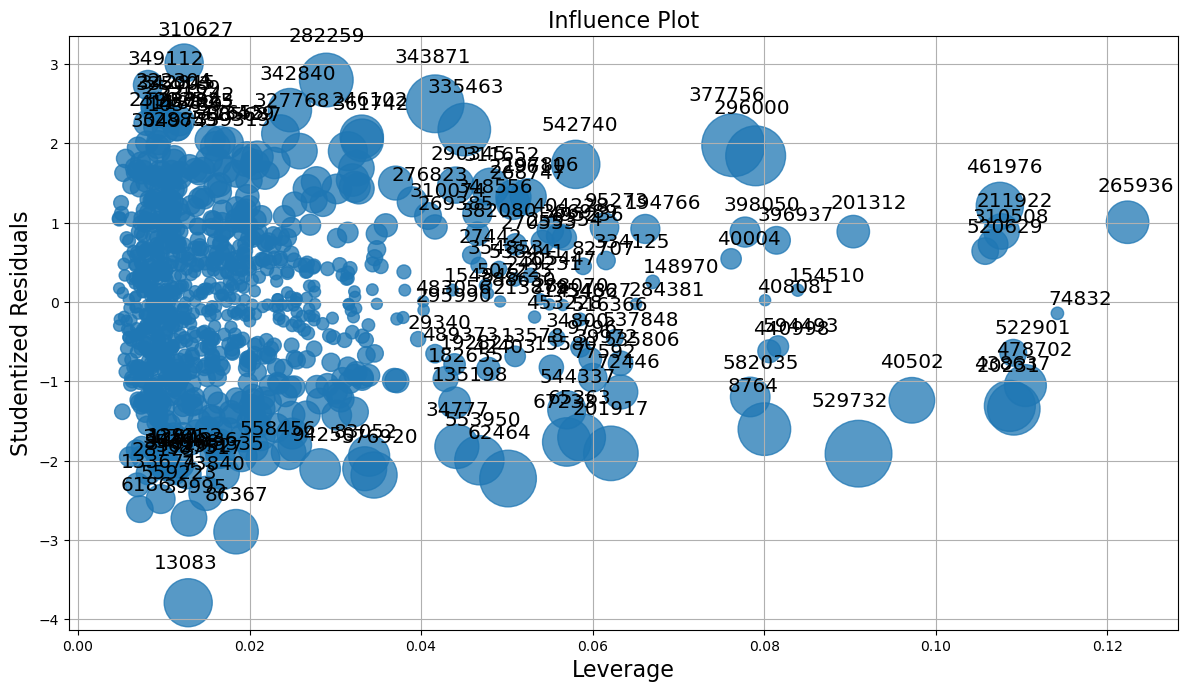

In [52]:
# Refazendo o modelo sem os pontos e plotando
reg_sample = smf.ols("""np.log(renda) ~ sexo + posse_de_veiculo + posse_de_imovel 
                        + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia 
                        + idade + tempo_emprego + qt_pessoas_residencia""", 
                     data=df_sample).fit()

fig, ax = plt.subplots(figsize=[12,7])
fig = sm.graphics.influence_plot(reg_sample, criterion = 'cook', ax=ax)
fig.tight_layout(pad=1.0)
ax.grid()

reg_sample.summary()

> O modelo não apresentou melhoras significativas.
>
> Apesar de ainda existirem pontos de grande influência é nítido que estão mais bem distribuídos em relação aos demais dados.


## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- *Adicionar a associação de Cramer*
- VIF

In [53]:
# Avaliando a correlação de Pearson nos dados
df_num = df_train.select_dtypes('number')
pearson_corr = df_num.corr(method='pearson')
pearson_corr

qtd_filhos     idade  tempo_emprego  \
qtd_filhos               1.000000 -0.293213      -0.076391   
idade                   -0.293213  1.000000       0.330701   
tempo_emprego           -0.076391  0.330701       1.000000   
qt_pessoas_residencia    0.902511 -0.258990      -0.066800   
renda                   -0.058154  0.187317       0.487477   

                       qt_pessoas_residencia     renda  
qtd_filhos                          0.902511 -0.058154  
idade                              -0.258990  0.187317  
tempo_emprego                      -0.066800  0.487477  
qt_pessoas_residencia               1.000000 -0.064589  
renda                              -0.064589  1.000000

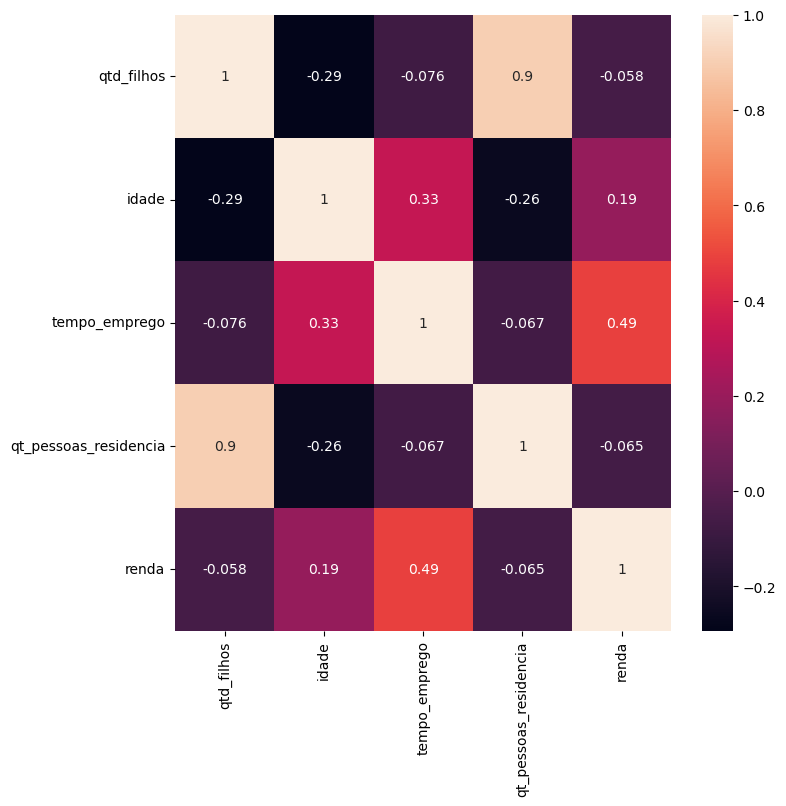

In [54]:
plt.figure(figsize=[8,8])
sns.heatmap(pearson_corr, annot=True);

#### Correlação de Spearman

In [55]:
df_num = df_train.select_dtypes('number')
pearson_corr = df_num.corr(method='spearman')
pearson_corr

qtd_filhos     idade  tempo_emprego  \
qtd_filhos               1.000000 -0.325667      -0.053773   
idade                   -0.325667  1.000000       0.265311   
tempo_emprego           -0.053773  0.265311       1.000000   
qt_pessoas_residencia    0.858890 -0.269122      -0.027153   
renda                   -0.048520  0.218807       0.596885   

                       qt_pessoas_residencia     renda  
qtd_filhos                          0.858890 -0.048520  
idade                              -0.269122  0.218807  
tempo_emprego                      -0.027153  0.596885  
qt_pessoas_residencia               1.000000 -0.034546  
renda                              -0.034546  1.000000

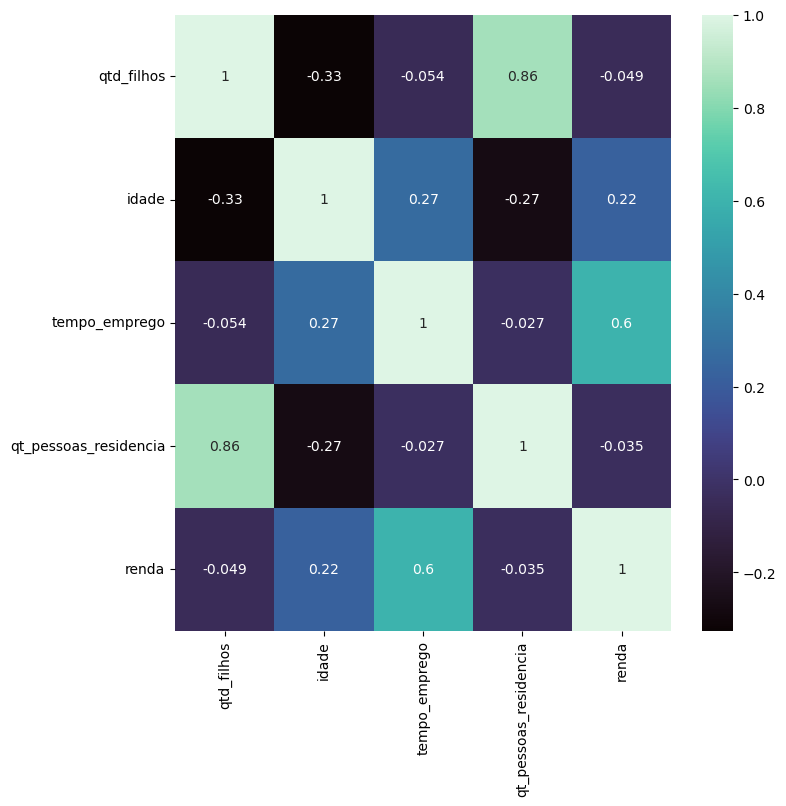

In [56]:
plt.figure(figsize=[8,8])
sns.heatmap(pearson_corr, annot=True, cmap='mako');

#### V de Cramer

Aqui iremos aplicar a correlação V de Cramer para todas as variáveis presentes no DataFrame.

In [57]:
def cramers_corrected_stat(x, y):
    """ calculate Cramers V statistic for categorial-categorial association"""
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]
        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
        return result


def cram(x, y, max_cat=5):
    if (np.dtype(x) in {np.dtype('float64'), np.dtype('int64')}) \
        and (len(np.unique(x)) > max_cat):
            x_ = pd.qcut(x, max_cat, duplicates='drop') 
    else: x_ = x
    if (np.dtype(y) in {np.dtype('float64'), np.dtype('int64')}) \
        and (len(np.unique(y)) > max_cat):
            y_ = pd.qcut(y, max_cat, duplicates='drop')
    else: y_ = y
        
    return cramers_corrected_stat(x_ ,y_)

In [58]:
variables = list(df.columns)
variables.remove('data_ref')
variables.remove('renda')
variables

['sexo',
 'posse_de_veiculo',
 'posse_de_imovel',
 'qtd_filhos',
 'tipo_renda',
 'educacao',
 'estado_civil',
 'tipo_residencia',
 'idade',
 'tempo_emprego',
 'qt_pessoas_residencia']

In [59]:
# Construir uma matriz vazia para acomodar as associações
matriz_cramer = pd.DataFrame(np.zeros((len(variables),len(variables))), 
             columns=variables, 
             index=variables)

# Calcular as associações
for var1 in variables:
    for var2 in variables:
        matriz_cramer.loc[var1, var2] = cram(df_train[var1], df_train[var2], 5)
        
matriz_cramer

sexo  posse_de_veiculo  posse_de_imovel  \
sexo                   1.000000          0.344186         0.040989   
posse_de_veiculo       0.344186          1.000000         0.001926   
posse_de_imovel        0.040989          0.001926         1.000000   
qtd_filhos             0.065153          0.062141         0.000414   
tipo_renda             0.079826          0.034914         0.023953   
educacao               0.046675          0.083640         0.055846   
estado_civil           0.153107          0.158928         0.041382   
tipo_residencia        0.082017          0.044813         0.213871   
idade                  0.146052          0.108898         0.095032   
tempo_emprego          0.123780          0.073211         0.008877   
qt_pessoas_residencia  0.101042          0.099063         0.024225   

                       qtd_filhos  tipo_renda  educacao  estado_civil  \
sexo                     0.065153    0.079826  0.046675      0.153107   
posse_de_veiculo         0.062141    0.034914  0.083640      0.158928   
posse_de_imovel          0.000414    0.023953  0.055846      0.041382   
qtd_filhos               1.000000    0.053624  0.032587      0.158429   
tipo_renda               0.053624    1.000000  0.069895      0.035995   
educacao                 0.032587    0.069895  1.000000      0.036960   
estado_civil             0.158429    0.035995  0.036960      1.000000   
tipo_residencia          0.032879    0.029876  0.054945      0.046644   
idade                    0.268311    0.041203  0.108758      0.110643   
tempo_emprego            0.036540    0.085155  0.042152      0.044695   
qt_pessoas_residencia    0.977036    0.040244  0.043930      0.230850   

                       tipo_residencia     idade  tempo_emprego  \
sexo                          0.082017  0.146052       0.123780   
posse_de_veiculo              0.044813  0.108898       0.073211   
posse_de_imovel               0.213871  0.095032       0.008877   
qtd_filhos                    0.032879  0.268311       0.036540   
tipo_renda                    0.029876  0.041203       0.085155   
educacao                      0.054945  0.108758       0.042152   
estado_civil                  0.046644  0.110643       0.044695   
tipo_residencia               1.000000  0.094918       0.057150   
idade                         0.094918  1.000000       0.150743   
tempo_emprego                 0.057150  0.150743       1.000000   
qt_pessoas_residencia         0.043970  0.281557       0.073562   

                       qt_pessoas_residencia  
sexo                                0.101042  
posse_de_veiculo                    0.099063  
posse_de_imovel                     0.024225  
qtd_filhos                          0.977036  
tipo_renda                          0.040244  
educacao                            0.043930  
estado_civil                        0.230850  
tipo_residencia                     0.043970  
idade                               0.281557  
tempo_emprego                       0.073562  
qt_pessoas_residencia               1.000000

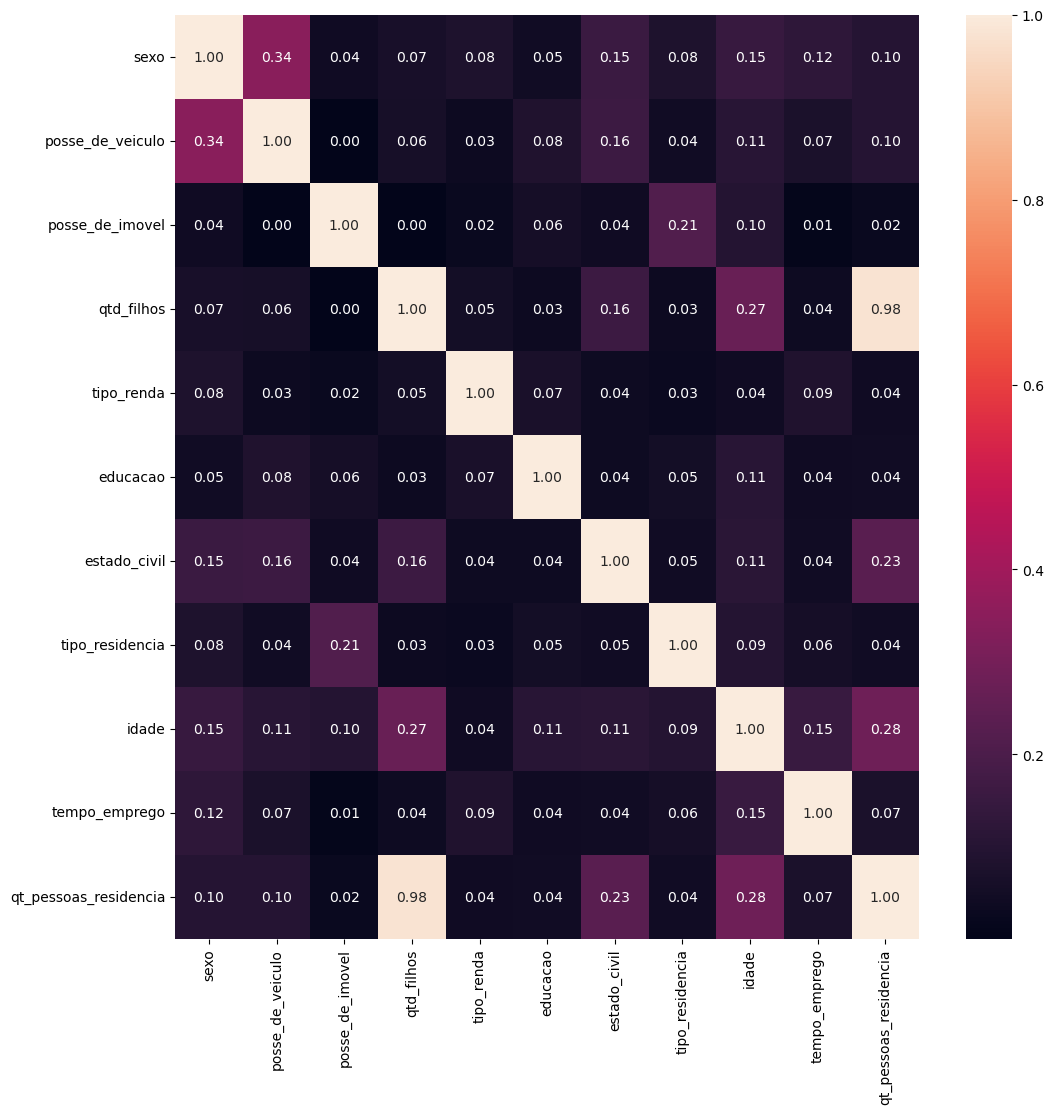

In [60]:
plt.figure(figsize=[12,12])
sns.heatmap(matriz_cramer, annot=True, fmt='.2f');

A correlação 2x2 entre as variáveis `qtd_filhos` e `qt_pessoas_residencia`  salta aos olhos com a análise da matriz de correlação V de Cramer e do `heatmap`.

#### Variance inflation factor (VIF)

In [81]:
vars = ['renda', 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda',
        'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego',
        'qt_pessoas_residencia']

In [82]:
# Gerando variáveis dummies para avaliação

df_dum = pd.get_dummies(df_train[vars],
                        drop_first = True,
                        dtype = 'int')

df_dum.head()

renda  qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  sexo_M  \
0  11138.14           0     47      16.717808                    2.0       1   
1   2424.81           0     30       9.600000                    2.0       1   
2  13749.66           0     28       8.208219                    2.0       1   
3   2361.84           2     44       1.301370                    4.0       1   
4    790.78           2     33       1.254795                    4.0       0   

   posse_de_veiculo_S  posse_de_imovel_S  tipo_renda_Bolsista  \
0                   1                  0                    0   
1                   1                  0                    0   
2                   1                  0                    0   
3                   0                  1                    0   
4                   0                  1                    0   

   tipo_renda_Empresário  ...  educacao_Superior incompleto  \
0                      1  ...                             0   
1                      0  ...                             1   
2                      0  ...                             0   
3                      0  ...                             0   
4                      0  ...                             0   

   estado_civil_Separado  estado_civil_Solteiro  estado_civil_União  \
0                      0                      0                   0   
1                      0                      0                   0   
2                      0                      0                   0   
3                      0                      0                   0   
4                      0                      0                   0   

   estado_civil_Viúvo  tipo_residencia_Casa  tipo_residencia_Com os pais  \
0                   0                     1                            0   
1                   0                     1                            0   
2                   0                     1                            0   
3                   0                     1                            0   
4                   0                     1                            0   

   tipo_residencia_Comunitário  tipo_residencia_Estúdio  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   

   tipo_residencia_Governamental  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  

[5 rows x 25 columns]

In [84]:
# renomeando colunas do dataframe (removendo espaços)

df_dum.columns = [_.replace(' ', '_') for _ in df_dum.columns]
df_dum.head(2)

renda  qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  sexo_M  \
0  11138.14           0     47      16.717808                    2.0       1   
1   2424.81           0     30       9.600000                    2.0       1   

   posse_de_veiculo_S  posse_de_imovel_S  tipo_renda_Bolsista  \
0                   1                  0                    0   
1                   1                  0                    0   

   tipo_renda_Empresário  ...  educacao_Superior_incompleto  \
0                      1  ...                             0   
1                      0  ...                             1   

   estado_civil_Separado  estado_civil_Solteiro  estado_civil_União  \
0                      0                      0                   0   
1                      0                      0                   0   

   estado_civil_Viúvo  tipo_residencia_Casa  tipo_residencia_Com_os_pais  \
0                   0                     1                            0   
1                   0                     1                            0   

   tipo_residencia_Comunitário  tipo_residencia_Estúdio  \
0                            0                        0   
1                            0                        0   

   tipo_residencia_Governamental  
0                              0  
1                              0  

[2 rows x 25 columns]

In [85]:
df_dum_exp = df_dum.drop(columns=['renda'])
df_dum_exp.head(1)

qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia  sexo_M  \
0           0     47      16.717808                    2.0       1   

   posse_de_veiculo_S  posse_de_imovel_S  tipo_renda_Bolsista  \
0                   1                  0                    0   

   tipo_renda_Empresário  tipo_renda_Pensionista  ...  \
0                      1                       0  ...   

   educacao_Superior_incompleto  estado_civil_Separado  estado_civil_Solteiro  \
0                             0                      0                      0   

   estado_civil_União  estado_civil_Viúvo  tipo_residencia_Casa  \
0                   0                   0                     1   

   tipo_residencia_Com_os_pais  tipo_residencia_Comunitário  \
0                            0                            0   

   tipo_residencia_Estúdio  tipo_residencia_Governamental  
0                        0                              0  

[1 rows x 24 columns]

In [86]:
# Testando o vif
vif(df_dum_exp, 0), vif(df_dum_exp, 1), vif(df_dum_exp, 2)

(43.85350613499, 26.78090026355606, 2.7318854188035018)

In [66]:
# Gerando um dataframe para o VIF

df_vif = pd.DataFrame()
df_vif['VIF factor'] = [vif(df_dum_exp, i) for i in range(df_dum_exp.shape[1])]
df_vif['Feature'] = df_dum_exp.columns

df_vif.round(2)

VIF factor                        Feature
0        43.85                     qtd_filhos
1        26.78                          idade
2         2.73                  tempo_emprego
3       287.69          qt_pessoas_residencia
4         1.87                         sexo_M
5         2.03             posse_de_veiculo_S
6         3.04              posse_de_imovel_S
7         1.00            tipo_renda_Bolsista
8         1.48          tipo_renda_Empresário
9         1.00         tipo_renda_Pensionista
10        1.21    tipo_renda_Servidor_público
11       71.32                 educacao_Médio
12        1.15         educacao_Pós_graduação
13       41.94     educacao_Superior_completo
14        6.32   educacao_Superior_incompleto
15        3.74          estado_civil_Separado
16        6.47          estado_civil_Solteiro
17        1.13             estado_civil_União
18        2.15             estado_civil_Viúvo
19       56.24           tipo_residencia_Casa
20        4.29    tipo_residencia_Com_os_pais
21        1.33    tipo_residencia_Comunitário
22        1.49        tipo_residencia_Estúdio
23        3.00  tipo_residencia_Governamental

**Os valores de VIF:**
- VIF = 1 indica que as variáveis não são correlacionadas
- 1 < VIF < 5 - indica que as variáveis são moderadamente correlacionadas
- VIF > 5 - indica que as variáveis são altamente correlacionadas 

In [67]:
# Vamos considerar as variáveis moderadamente correlacionadas

df_vif[df_vif['VIF factor'] < 5]

VIF factor                        Feature
2     2.731885                  tempo_emprego
4     1.867635                         sexo_M
5     2.026170             posse_de_veiculo_S
6     3.038404              posse_de_imovel_S
7     1.004596            tipo_renda_Bolsista
8     1.481186          tipo_renda_Empresário
9     1.002446         tipo_renda_Pensionista
10    1.208938    tipo_renda_Servidor_público
12    1.152139         educacao_Pós_graduação
15    3.739346          estado_civil_Separado
17    1.130500             estado_civil_União
18    2.151748             estado_civil_Viúvo
20    4.289660    tipo_residencia_Com_os_pais
21    1.329698    tipo_residencia_Comunitário
22    1.486646        tipo_residencia_Estúdio
23    2.997955  tipo_residencia_Governamental

##### Refazendo o modelo para as variáveis selecionadas pelo VIF, com as quais podemos minimizar o efeito da multicolinearidade

In [68]:
# Obtendo as variáveis de interesse

vif_list = list(df_vif[df_vif['VIF factor'] < 5]['Feature'])
vif_list = [_.replace(' ', '_') for _ in vif_list]
vars_vif = ' + '.join(vif_list)
vars_vif

'tempo_emprego + sexo_M + posse_de_veiculo_S + posse_de_imovel_S + tipo_renda_Bolsista + tipo_renda_Empresário + tipo_renda_Pensionista + tipo_renda_Servidor_público + educacao_Pós_graduação + estado_civil_Separado + estado_civil_União + estado_civil_Viúvo + tipo_residencia_Com_os_pais + tipo_residencia_Comunitário + tipo_residencia_Estúdio + tipo_residencia_Governamental'

In [69]:
# Modelo
reg_vif = smf.ols('np.log(renda) ~ '+ vars_vif, data = df_dum).fit()
reg_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                 2.827e+04
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        08:32:18   Log-Likelihood:            -6.6511e+05
No. Observations:              499269   AIC:                         1.330e+06
Df Residuals:                  499252   BIC:                         1.330e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         8.0870      0.003   2327.396      0.000       8.080       8.094
tempo_emprego                     0.1305      0.000    654.815      0.000       0.130       0.131
sexo_M                            0.1288      0.003     44.015      0.000       0.123       0.135
posse_de_veiculo_S                0.0061      0.003      2.167      0.030       0.001       0.012
posse_de_imovel_S                 0.1879      0.003     67.326      0.000       0.182       0.193
tipo_renda_Bolsista              -0.1237      0.053     -2.353      0.019      -0.227      -0.021
tipo_renda_Empresário             0.1515      0.003     50.699      0.000       0.146       0.157
tipo_renda_Pensionista           -0.0742      0.058     -1.268      0.205      -0.189       0.041
tipo_renda_Servidor_público       0.1463      0.004     33.289      0.000       0.138       0.155
educacao_Pós_graduação            0.0974      0.037      2.663      0.008       0.026       0.169
estado_civil_Separado             0.0241      0.006      4.301      0.000       0.013       0.035
estado_civil_União               -0.0043      0.005     -0.901      0.368      -0.014       0.005
estado_civil_Viúvo                0.0151      0.009      1.742      0.081      -0.002       0.032
tipo_residencia_Com_os_pais       0.0124      0.006      2.112      0.035       0.001       0.024
tipo_residencia_Comunitário      -0.0346      0.018     -1.922      0.055      -0.070       0.001
tipo_residencia_Estúdio          -0.0582      0.015     -3.896      0.000      -0.087      -0.029
tipo_residencia_Governamental     0.0162      0.007      2.178      0.029       0.002       0.031
==============================================================================
Omnibus:                      832.140   Durbin-Watson:                   1.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              728.348
Skew:                          -0.046   Prob(JB):                    6.94e-159
Kurtosis:                       2.837   Cond. No.                         463.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

O modelo agora está mais legível e com uma multicolinearidade menor se comparado ao modelo anterior. Podemos torná-lo ainda mais simples avaliando os valores das estatísticas, como o P-value. 

Façamos isso.

In [70]:
# Removendo as 4 variáveis de valores de p-value acima de 0.05

reg_vif = smf.ols("""np.log(renda) ~ tempo_emprego + sexo_M + posse_de_veiculo_S 
                    + posse_de_imovel_S + tipo_renda_Bolsista + tipo_renda_Empresário 
                    + tipo_renda_Servidor_público + educacao_Pós_graduação 
                    + estado_civil_Separado + tipo_residencia_Com_os_pais + tipo_residencia_Estúdio 
                    + tipo_residencia_Governamental""", data = df_dum).fit()
reg_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                 3.769e+04
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        08:32:18   Log-Likelihood:            -6.6512e+05
No. Observations:              499269   AIC:                         1.330e+06
Df Residuals:                  499256   BIC:                         1.330e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         8.0867      0.003   2376.986      0.000       8.080       8.093
tempo_emprego                     0.1305      0.000    655.392      0.000       0.130       0.131
sexo_M                            0.1285      0.003     44.127      0.000       0.123       0.134
posse_de_veiculo_S                0.0059      0.003      2.111      0.035       0.000       0.011
posse_de_imovel_S                 0.1882      0.003     67.513      0.000       0.183       0.194
tipo_renda_Bolsista              -0.1238      0.053     -2.356      0.018      -0.227      -0.021
tipo_renda_Empresário             0.1515      0.003     50.772      0.000       0.146       0.157
tipo_renda_Servidor_público       0.1464      0.004     33.305      0.000       0.138       0.155
educacao_Pós_graduação            0.0974      0.037      2.661      0.008       0.026       0.169
estado_civil_Separado             0.0241      0.006      4.320      0.000       0.013       0.035
tipo_residencia_Com_os_pais       0.0124      0.006      2.111      0.035       0.001       0.024
tipo_residencia_Estúdio          -0.0583      0.015     -3.904      0.000      -0.088      -0.029
tipo_residencia_Governamental     0.0168      0.007      2.254      0.024       0.002       0.031
==============================================================================
Omnibus:                      832.376   Durbin-Watson:                   1.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              728.599
Skew:                          -0.046   Prob(JB):                    6.12e-159
Kurtosis:                       2.837   Cond. No.                         416.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> **Note que o modelo manteve o mesmo R-quadrado porém agora possui um menor número de variáveis.**

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

#### 1 - O modelo original aplicado aos dados de teste (não foram implementadas modificações)

In [71]:
df_test.columns

Index(['data_ref', 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda'],
      dtype='object')

In [72]:
reg_test_inicial = smf.ols("""np.log(renda) ~ sexo + posse_de_veiculo + posse_de_imovel
                            + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia
                            + idade + tempo_emprego + qt_pessoas_residencia""", data = df_test).fit()
reg_test_inicial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     7363.
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        08:32:22   Log-Likelihood:            -1.3896e+05
No. Observations:              124971   AIC:                         2.780e+05
Df Residuals:                  124946   BIC:                         2.782e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            6.5156      0.079     82.734      0.000       6.361       6.670
sexo[T.M]                            0.1314      0.005     27.911      0.000       0.122       0.141
posse_de_veiculo[T.S]                0.0100      0.005      2.198      0.028       0.001       0.019
posse_de_imovel[T.S]                 0.1856      0.004     41.335      0.000       0.177       0.194
tipo_renda[T.Bolsista]              -0.3398      0.087     -3.912      0.000      -0.510      -0.170
tipo_renda[T.Empresário]             0.1482      0.005     30.829      0.000       0.139       0.158
tipo_renda[T.Pensionista]           -0.0345      0.091     -0.380      0.704      -0.212       0.143
tipo_renda[T.Servidor público]       0.1234      0.007     17.459      0.000       0.110       0.137
educacao[T.Médio]                    0.0081      0.024      0.341      0.733      -0.038       0.055
educacao[T.Pós graduação]            0.1282      0.061      2.100      0.036       0.009       0.248
educacao[T.Superior completo]        0.1102      0.024      4.645      0.000       0.064       0.157
educacao[T.Superior incompleto]      0.0600      0.026      2.350      0.019       0.010       0.110
estado_civil[T.Separado]             0.1472      0.037      3.925      0.000       0.074       0.221
estado_civil[T.Solteiro]             0.1328      0.037      3.620      0.000       0.061       0.205
estado_civil[T.União]                0.0122      0.008      1.565      0.118      -0.003       0.027
estado_civil[T.Viúvo]                0.0951      0.039      2.430      0.015       0.018       0.172
tipo_residencia[T.Casa]             -0.0807      0.017     -4.878      0.000      -0.113      -0.048
tipo_residencia[T.Com os pais]      -0.0495      0.019     -2.648      0.008      -0.086      -0.013
tipo_residencia[T.Comunitário]      -0.1564      0.033     -4.720      0.000      -0.221      -0.091
tipo_residencia[T.Estúdio]          -0.1257      0.029     -4.320      0.000      -0.183      -0.069
tipo_residencia[T.Governamental]    -0.0442      0.020     -2.191      0.028      -0.084      -0.005
qtd_filhos                          -0.1172      0.036     -3.214      0.001      -0.189      -0.046
idade                                0.0044      0.000     17.189      0.000       0.004       0.005
tempo_emprego                        0.1290      0.000    383.965      0.000       0.128       0.130
qt_pessoas_residencia                0.1216      0.036      3.341      0.001       0.050       0.193
==============================================================================
Omnibus:                        9.003   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.068
Skew:             

> **O modelo original, sem alterações, foi capaz de gerar um bom R-quadrado na base de testes.**

Agora, vamos avaliar o modelo com os tratamentos.

#### 2 - Modelo ajustado 

Para este caso façamos uma análise dos dados, a distribuição dos resíduos do modelo e também uma análise do VIF (*variance inflation factor*)

In [358]:
# Os dados de teste
df_test = df[df.data_ref > '2015-12-01']
df_test.head()

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
600001 2016-01-01    F                N               S           2   
600002 2016-01-01    F                S               S           3   
600003 2016-01-01    M                S               S           3   
600004 2016-01-01    F                S               N           0   
600005 2016-01-01    F                N               S           0   

              tipo_renda           educacao estado_civil tipo_residencia  \
600001  Servidor público  Superior completo       Casado            Casa   
600002       Assalariado              Médio       Casado            Casa   
600003  Servidor público              Médio       Casado            Casa   
600004       Assalariado              Médio        Viúvo            Casa   
600005       Assalariado              Médio       Casado            Casa   

        idade  tempo_emprego  qt_pessoas_residencia     renda  
600001     27       9.301370                    4.0  13884.35  
600002     38      10.967123                    5.0  11042.47  
600003     35       5.553425                    5.0   1333.82  
600004     63       9.265753                    1.0  17633.03  
600005     36       2.128767                    2.0    712.80

##### Antes de avaliar o VIF, vejamos como se apresenta a matriz de correlação de V de Cramer nestes dados

In [359]:
variables = df_test.columns

In [360]:
# Construir uma matriz vazia para acomodar as associações
matriz_cramer = pd.DataFrame(np.zeros((len(variables),len(variables))), 
             columns=variables, 
             index=variables)

# Calcular as associações
for var1 in variables:
    for var2 in variables:
        matriz_cramer.loc[var1, var2] = cram(df_test[var1], df_test[var2], 5)
        
matriz_cramer

data_ref      sexo  posse_de_veiculo  posse_de_imovel  \
data_ref               1.000000  0.000115          0.002257         0.000000   
sexo                   0.000115  1.000000          0.343650         0.037830   
posse_de_veiculo       0.002257  0.343650          1.000000         0.000747   
posse_de_imovel        0.000000  0.037830          0.000747         1.000000   
qtd_filhos             0.000000  0.063865          0.061218         0.000000   
tipo_renda             0.005958  0.073033          0.028285         0.025994   
educacao               0.003717  0.043682          0.065567         0.053833   
estado_civil           0.001713  0.150841          0.156675         0.041182   
tipo_residencia        0.002274  0.083446          0.046357         0.213435   
idade                  0.003254  0.142564          0.103656         0.095621   
tempo_emprego          0.003834  0.123470          0.072379         0.004328   
qt_pessoas_residencia  0.000000  0.095263          0.096461         0.024560   
renda                  0.107081  0.143608          0.063671         0.083266   

                       qtd_filhos  tipo_renda  educacao  estado_civil  \
data_ref                 0.000000    0.005958  0.003717      0.001713   
sexo                     0.063865    0.073033  0.043682      0.150841   
posse_de_veiculo         0.061218    0.028285  0.065567      0.156675   
posse_de_imovel          0.000000    0.025994  0.053833      0.041182   
qtd_filhos               1.000000    0.055940  0.026662      0.162909   
tipo_renda               0.055940    1.000000  0.059235      0.035503   
educacao                 0.026662    0.059235  1.000000      0.034691   
estado_civil             0.162909    0.035503  0.034691      1.000000   
tipo_residencia          0.034071    0.032770  0.051725      0.046416   
idade                    0.269163    0.040197  0.097709      0.112318   
tempo_emprego            0.035295    0.083721  0.038868      0.041699   
qt_pessoas_residencia    0.977692    0.041781  0.037260      0.232795   
renda                    0.033882    0.063102  0.030706      0.031688   

                       tipo_residencia     idade  tempo_emprego  \
data_ref                      0.002274  0.003254       0.003834   
sexo                          0.083446  0.142564       0.123470   
posse_de_veiculo              0.046357  0.103656       0.072379   
posse_de_imovel               0.213435  0.095621       0.004328   
qtd_filhos                    0.034071  0.269163       0.035295   
tipo_renda                    0.032770  0.040197       0.083721   
educacao                      0.051725  0.097709       0.038868   
estado_civil                  0.046416  0.112318       0.041699   
tipo_residencia               1.000000  0.095615       0.057969   
idade                         0.095615  1.000000       0.149680   
tempo_emprego                 0.057969  0.149680       1.000000   
qt_pessoas_residencia         0.042328  0.281499       0.071155   
renda                         0.038118  0.125844       0.373047   

                       qt_pessoas_residencia     renda  
data_ref                            0.000000  0.107081  
sexo                                0.095263  0.143608  
posse_de_veiculo                    0.096461  0.063671  
posse_de_imovel                     0.024560  0.083266  
qtd_filhos                          0.977692  0.033882  
tipo_renda                          0.041781  0.063102  
educacao                            0.037260  0.030706  
estado_civil                        0.232795  0.031688  
tipo_residencia                     0.042328  0.038118  
idade                               0.281499  0.125844  
tempo_emprego                       0.071155  0.373047  
qt_pessoas_residencia               1.000000  0.059987  
renda                               0.059987  1.000000

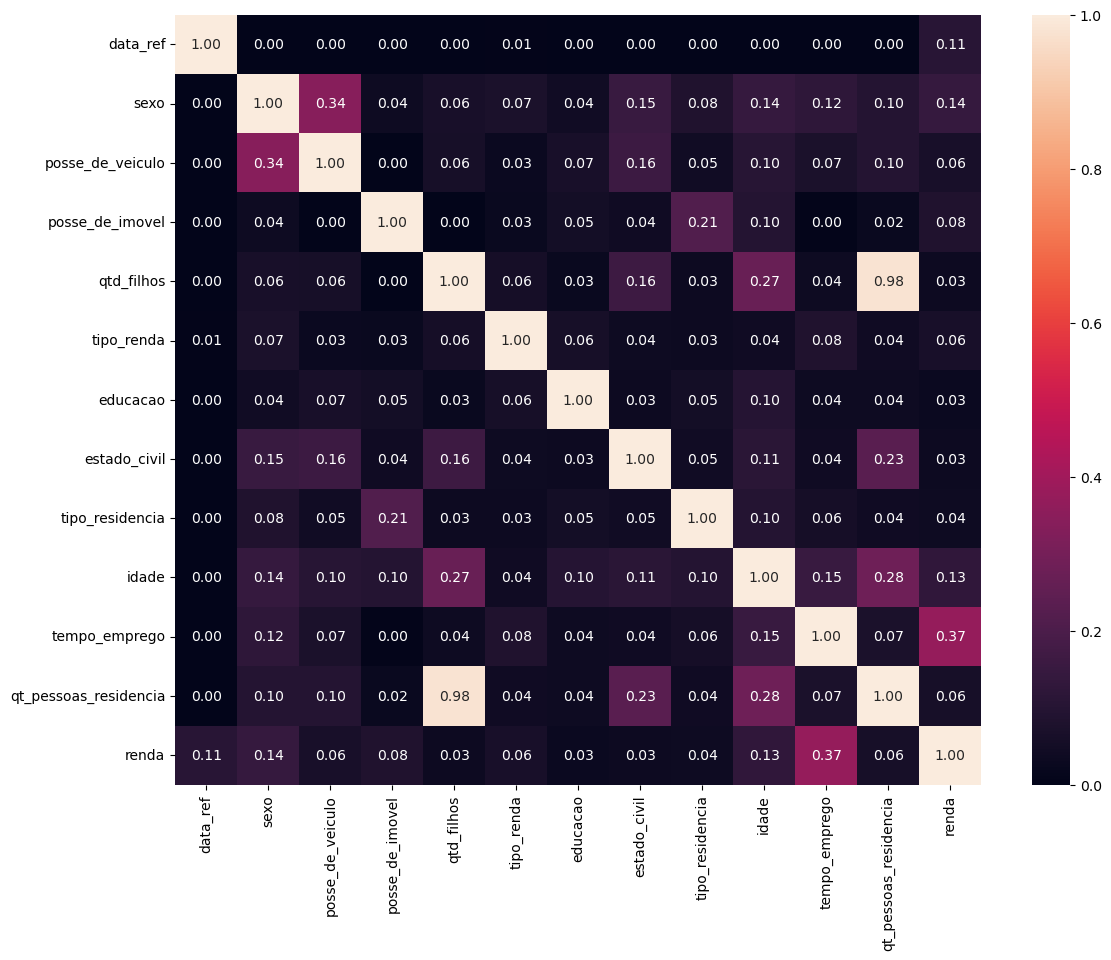

In [361]:
# Visualização gráfica

plt.figure(figsize=[13,10])
sns.heatmap(matriz_cramer, annot=True, fmt='.2f');

É possível notar algumas correlações significativas entre algumas variáveis. Note que `qtd_filhos` e `qt_pessoas_residencia` possuem correlação alta isso provavelmente irá implicar em um alto valor de VIF. 

Façamos agora a análise do VIF, pois nesse termos uma maior discriminação das variáveis e suas componentes.

##### Avaliando o VIF


In [362]:
# Variáveis como dummies (variáveis categóricas)

df_test_dummy = pd.get_dummies(df_test, drop_first=True, dtype='int')
# Eliminando espaços nos nomes das colunas
df_test_dummy.columns = [var.replace(' ', '_') for var in df_test_dummy.columns]
df_test_dummy.drop(columns=['data_ref'], inplace=True)
df_test_dummy.head()

qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia     renda  \
600001           2     27       9.301370                    4.0  13884.35   
600002           3     38      10.967123                    5.0  11042.47   
600003           3     35       5.553425                    5.0   1333.82   
600004           0     63       9.265753                    1.0  17633.03   
600005           0     36       2.128767                    2.0    712.80   

        sexo_M  posse_de_veiculo_S  posse_de_imovel_S  tipo_renda_Bolsista  \
600001       0                   0                  1                    0   
600002       0                   1                  1                    0   
600003       1                   1                  1                    0   
600004       0                   1                  0                    0   
600005       0                   0                  1                    0   

        tipo_renda_Empresário  ...  educacao_Superior_incompleto  \
600001                      0  ...                             0   
600002                      0  ...                             0   
600003                      0  ...                             0   
600004                      0  ...                             0   
600005                      0  ...                             0   

        estado_civil_Separado  estado_civil_Solteiro  estado_civil_União  \
600001                      0                      0                   0   
600002                      0                      0                   0   
600003                      0                      0                   0   
600004                      0                      0                   0   
600005                      0                      0                   0   

        estado_civil_Viúvo  tipo_residencia_Casa  tipo_residencia_Com_os_pais  \
600001                   0                     1                            0   
600002                   0                     1                            0   
600003                   0                     1                            0   
600004                   1                     1                            0   
600005                   0                     1                            0   

        tipo_residencia_Comunitário  tipo_residencia_Estúdio  \
600001                            0                        0   
600002                            0                        0   
600003                            0                        0   
600004                            0                        0   
600005                            0                        0   

        tipo_residencia_Governamental  
600001                              0  
600002                              0  
600003                              0  
600004                              0  
600005                              0  

[5 rows x 25 columns]

In [363]:
# Separando uma df sem a variável renda
df_vif = df_test_dummy.drop(columns=['renda'])
# Obtendo um DataFrame com o VIF 
vif_df = pd.DataFrame()
vif_df['VIF factor'] = [vif(df_vif, i) for i in range(df_vif.shape[1])]
vif_df['Feature'] = df_vif.columns

In [364]:
vif_df

VIF factor                        Feature
0    43.237984                     qtd_filhos
1    26.595561                          idade
2     2.728922                  tempo_emprego
3   282.193683          qt_pessoas_residencia
4     1.867996                         sexo_M
5     2.018023             posse_de_veiculo_S
6     3.022157              posse_de_imovel_S
7     1.003751            tipo_renda_Bolsista
8     1.479807          tipo_renda_Empresário
9     1.002617         tipo_renda_Pensionista
10    1.205699    tipo_renda_Servidor_público
11   57.998072                 educacao_Médio
12    1.163228         educacao_Pós_graduação
13   54.179795     educacao_Superior_completo
14    6.222294   educacao_Superior_incompleto
15    3.651505          estado_civil_Separado
16    6.432685          estado_civil_Solteiro
17    1.132318             estado_civil_União
18    2.084181             estado_civil_Viúvo
19   53.889513           tipo_residencia_Casa
20    4.140310    tipo_residencia_Com_os_pais
21    1.315534    tipo_residencia_Comunitário
22    1.460584        tipo_residencia_Estúdio
23    2.893532  tipo_residencia_Governamental

In [369]:
# Obtendo as variáveis de interesse por meio da seleção de um VIF menor que 5
variaveis = ' + '.join(vif_df[vif_df['VIF factor'] < 5]['Feature'])
variaveis

'tempo_emprego + sexo_M + posse_de_veiculo_S + posse_de_imovel_S + tipo_renda_Bolsista + tipo_renda_Empresário + tipo_renda_Pensionista + tipo_renda_Servidor_público + educacao_Pós_graduação + estado_civil_Separado + estado_civil_União + estado_civil_Viúvo + tipo_residencia_Com_os_pais + tipo_residencia_Comunitário + tipo_residencia_Estúdio + tipo_residencia_Governamental'

##### Gerando o modelo

In [371]:
reg_vif = smf.ols('np.log(renda) ~ ' + variaveis, data = df_test_dummy).fit()
reg_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                 1.092e+04
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:22:37   Log-Likelihood:            -1.3938e+05
No. Observations:              124971   AIC:                         2.788e+05
Df Residuals:                  124954   BIC:                         2.790e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         6.9055      0.006   1238.242      0.000       6.895       6.916
tempo_emprego                     0.1306      0.000    407.155      0.000       0.130       0.131
sexo_M                            0.1214      0.005     25.830      0.000       0.112       0.131
posse_de_veiculo_S                0.0137      0.005      3.033      0.002       0.005       0.023
posse_de_imovel_S                 0.1904      0.004     42.467      0.000       0.182       0.199
tipo_renda_Bolsista              -0.2522      0.087     -2.896      0.004      -0.423      -0.081
tipo_renda_Empresário             0.1541      0.005     32.092      0.000       0.145       0.163
tipo_renda_Pensionista           -0.0009      0.091     -0.010      0.992      -0.179       0.177
tipo_renda_Servidor_público       0.1352      0.007     19.159      0.000       0.121       0.149
educacao_Pós_graduação            0.0763      0.057      1.349      0.177      -0.035       0.187
estado_civil_Separado             0.0381      0.009      4.205      0.000       0.020       0.056
estado_civil_União               -0.0001      0.008     -0.015      0.988      -0.015       0.015
estado_civil_Viúvo                0.0032      0.014      0.227      0.820      -0.025       0.031
tipo_residencia_Com_os_pais       0.0099      0.009      1.041      0.298      -0.009       0.028
tipo_residencia_Comunitário      -0.0581      0.029     -2.009      0.045      -0.115      -0.001
tipo_residencia_Estúdio          -0.0350      0.024     -1.446      0.148      -0.083       0.012
tipo_residencia_Governamental     0.0261      0.012      2.161      0.031       0.002       0.050
==============================================================================
Omnibus:                        7.778   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.864
Skew:                           0.013   Prob(JB):                       0.0196
Kurtosis:                       3.030   Cond. No.                         448.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> **O modelo está legível e simplificado com base nas variáveis mais explicativas e relevantes definidas até agora, uma forma de simplificá-lo ainda mais no intuito de evitar overfitting e o uso de variáveis desnecessárias é avaliar as estatísticas fornecidas, como o P-value.**

In [372]:
# Avaliando o P-value

# Convertendo os valores para html
dados = StringIO(reg_vif.summary().tables[1].as_html())
# Lendo tais dados
tab = pd.read_html(dados, header=0, index_col=0)[0]
tab.style.format(precision=3).highlight_between(subset='P>|t|', left=.05)

In [373]:
# Refazendo o modelo desconsiderando altos p-values

reg_vif2 = smf.ols("""np.log(renda) ~ tempo_emprego + sexo_M + posse_de_veiculo_S + 
                    posse_de_imovel_S + tipo_renda_Bolsista + tipo_renda_Empresário + 
                    tipo_renda_Servidor_público + estado_civil_Separado + 
                    tipo_residencia_Comunitário + tipo_residencia_Governamental""", 
                    data = df_test_dummy).fit()
reg_vif2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                 1.747e+04
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:22:41   Log-Likelihood:            -1.3938e+05
No. Observations:              124971   AIC:                         2.788e+05
Df Residuals:                  124960   BIC:                         2.789e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         6.9068      0.005   1292.024      0.000       6.896       6.917
tempo_emprego                     0.1306      0.000    408.304      0.000       0.130       0.131
sexo_M                            0.1210      0.005     25.925      0.000       0.112       0.130
posse_de_veiculo_S                0.0137      0.005      3.032      0.002       0.005       0.023
posse_de_imovel_S                 0.1901      0.004     43.057      0.000       0.181       0.199
tipo_renda_Bolsista              -0.2527      0.087     -2.902      0.004      -0.423      -0.082
tipo_renda_Empresário             0.1539      0.005     32.097      0.000       0.144       0.163
tipo_renda_Servidor_público       0.1347      0.007     19.117      0.000       0.121       0.149
estado_civil_Separado             0.0377      0.009      4.176      0.000       0.020       0.055
tipo_residencia_Comunitário      -0.0585      0.029     -2.023      0.043      -0.115      -0.002
tipo_residencia_Governamental     0.0256      0.012      2.130      0.033       0.002       0.049
==============================================================================
Omnibus:                        7.836   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.918
Skew:                           0.013   Prob(JB):                       0.0191
Kurtosis:                       3.029   Cond. No.                         429.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Note como o modelo final possui boa legibilidade dos coeficientes e também um redução significativa no número de variáveis e, ainda assim, manteve o mesmo valores de R-quadrado**

##### Avaliando a dispersão dos resíduos

In [376]:
# Resíduo studentizado
influence = reg_vif2.get_influence()
st_res = influence.resid_studentized_internal

# Adicionando os resíduso studentizados ao dataframe

df_test.loc[:,'student_resid'] = st_res
df_test.head(3)

data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
600001 2016-01-01    F                N               S           2   
600002 2016-01-01    F                S               S           3   
600003 2016-01-01    M                S               S           3   

              tipo_renda           educacao estado_civil tipo_residencia  \
600001  Servidor público  Superior completo       Casado            Casa   
600002       Assalariado              Médio       Casado            Casa   
600003  Servidor público              Médio       Casado            Casa   

        idade  tempo_emprego  qt_pessoas_residencia     renda  student_resid  
600001     27       9.301370                    4.0  13884.35       1.480201  
600002     38      10.967123                    5.0  11042.47       1.039262  
600003     35       5.553425                    5.0   1333.82      -1.213199

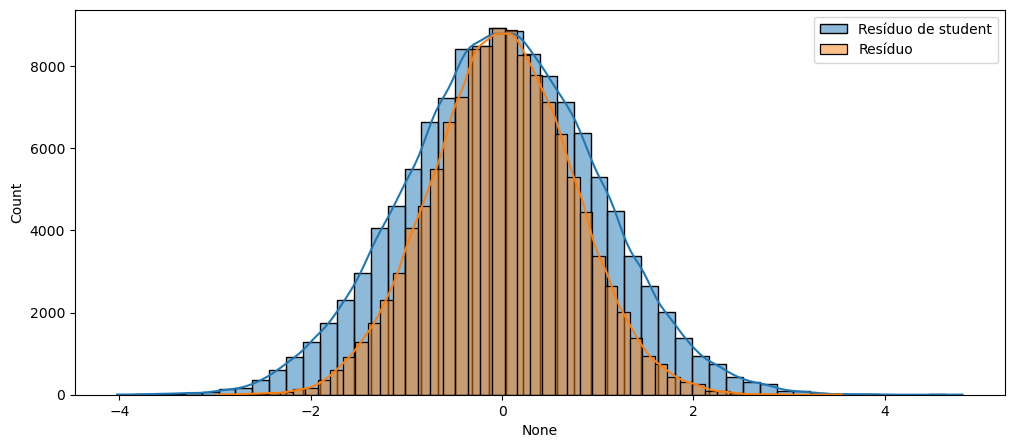

In [377]:
# Plot dos resíduos

fig, ax = plt.subplots(figsize=[12,5])
# Resíduo de student
sns.histplot(x = st_res, kde = True, bins=50, label='Resíduo de student', ax=ax)
# Resíduo
sns.histplot(x = reg_vif2.resid, kde = True, bins=50, label='Resíduo', ax=ax)
ax.legend()
plt.show()

A distribuição dos resíduos possui um perfil normal. Como podemos notar a partir dos resíduos de Student, o modelo aparenta possuir dados outliers ou muito discrepantes em relação aos demais, tipicamente um resíduos maiores que 2 já chama atenção e maiores que 3 podem ser um grande indício de outliers.

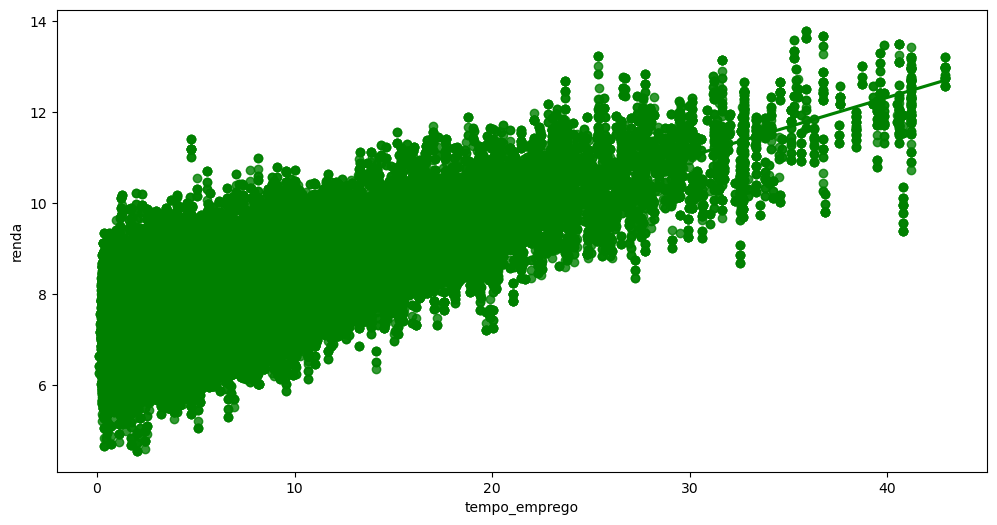

In [378]:
plt.figure(figsize=[12,6])
sns.regplot(y = np.log(df_test['renda']), 
            x = df_test['tempo_emprego'], 
            color='green')
plt.show()

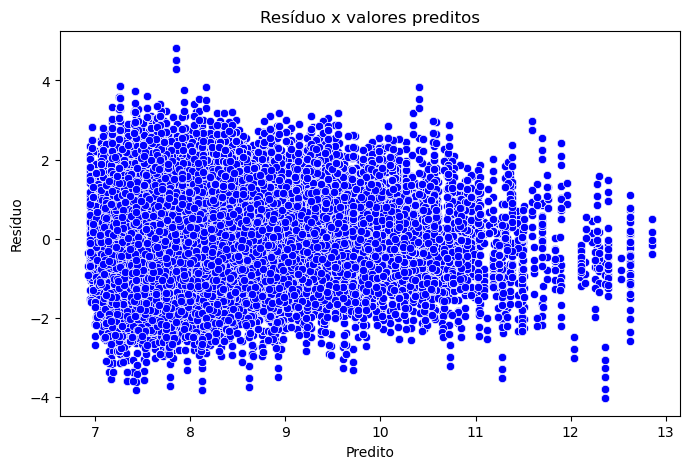

In [379]:
# Variância dos resíduos

fig, ax = plt.subplots(figsize=[8,5])

# obtendo resíduos studentizados
influence = reg_vif2.get_influence()
st_res = influence.resid_studentized_internal

sns.scatterplot(x = reg_vif2.predict(), y = st_res, color='blue', ax=ax)
ax.set_xlabel('Predito')
ax.set_ylabel('Resíduo')
ax.set_title('Resíduo x valores preditos');

Apesar de não possuirmos uma homocedasticidade perfeita, os dados apresentam uma boa distribuição dos resíduos em relação aos valores preditos.

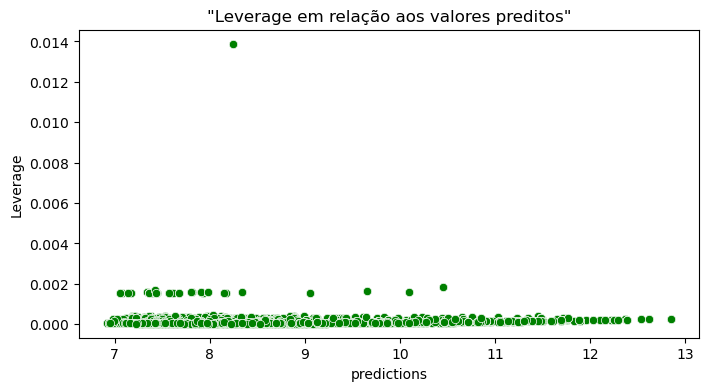

In [380]:
# Avaliando os pontos de influência e os valores previstos

influence = reg_vif2.get_influence()
leverage = influence.hat_matrix_diag

plt.figure(figsize=[8,4])
sns.scatterplot(x = reg_vif2.predict(), y = leverage, color='green')
plt.xlabel('predictions')
plt.ylabel('Leverage')
plt.title('"Leverage em relação aos valores preditos"')
plt.show()

Um ponto com `leverage` elevado não quer dizer, necessariamente, que o ponto é um outlier, mas um dado que tem um valor fora do escopo dos dados de treinamento, dessa forma o modelo falha em descrevê-lo.

##### Avaliando os resíduos em função das demais variáveis

In [381]:
df_test.columns

Index(['data_ref', 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'student_resid'],
      dtype='object')

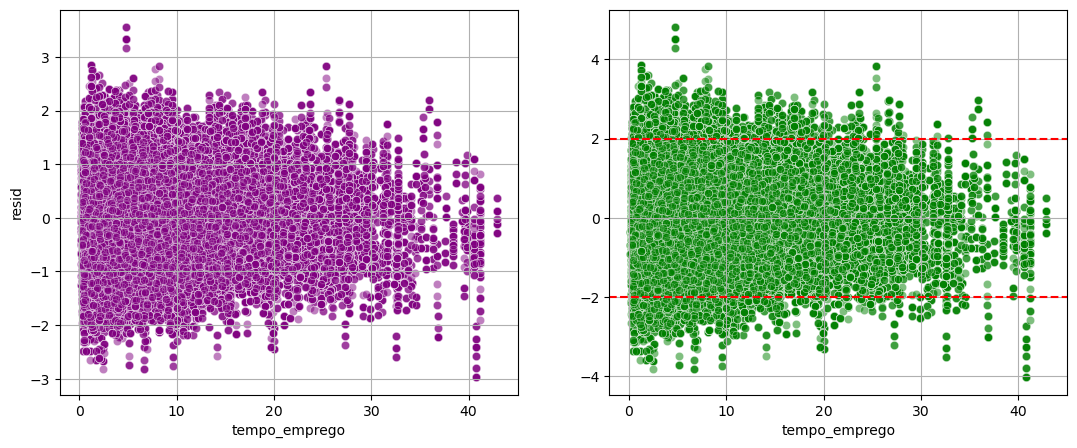

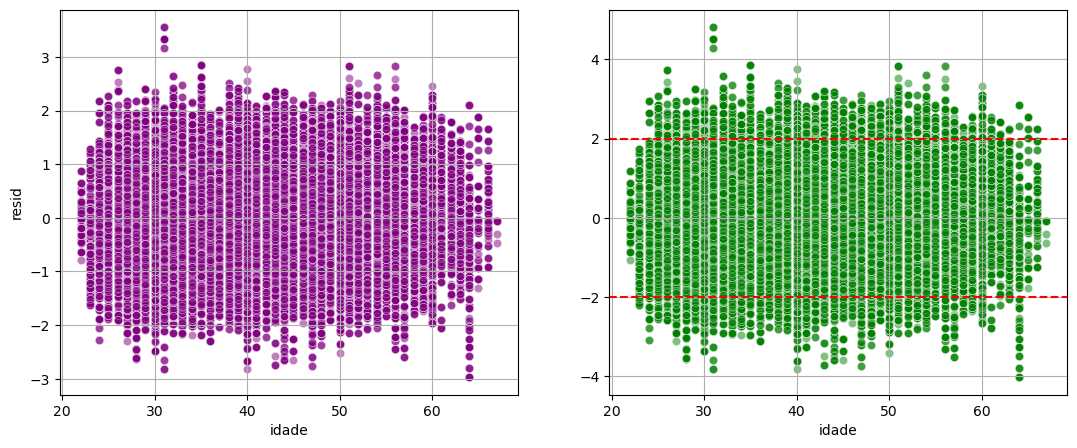

In [383]:
# Gráfico de resíduos e resíduos studentizados em função das variáveis (scatterplot)

vars = ['tempo_emprego', 'idade']

for var in vars:
    fig, ax = plt.subplots(1,2, figsize=[13, 5])
    
    sns.scatterplot(x=var, y=reg_vif2.resid, 
                    data=df_test, color='purple', 
                    alpha=.5, ax=ax[0])
    ax[0].set_ylabel('resid')
    ax[0].grid()
    sns.scatterplot(x=var, y=st_res, 
                    data=df_test, color='green', 
                    alpha=.5, ax=ax[1])
    ax[1].grid()
    ax[1].axhline(2, color='red', ls='--')
    ax[1].axhline(-2, color='red', ls='--')
    plt.show()

Analisando a distribuição dos resíduos studentizados note que há possível outliers, sendo os pontos mais impactantes aqueleas além das linhas tracejadas em vermelho.

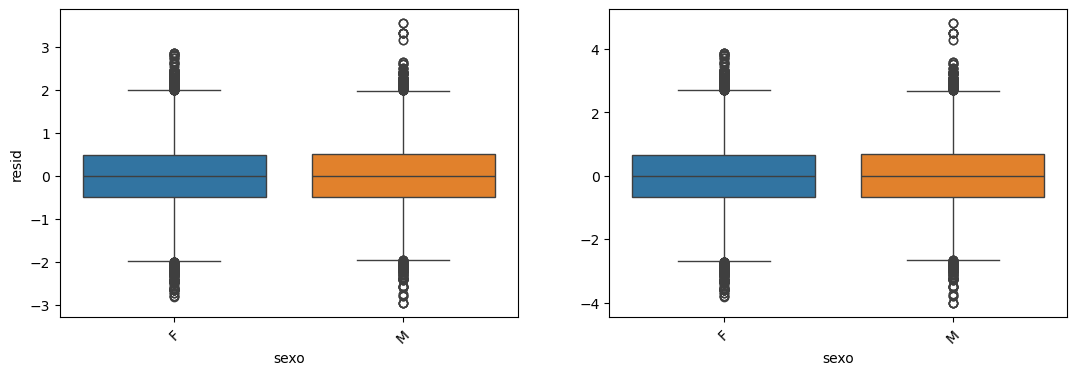

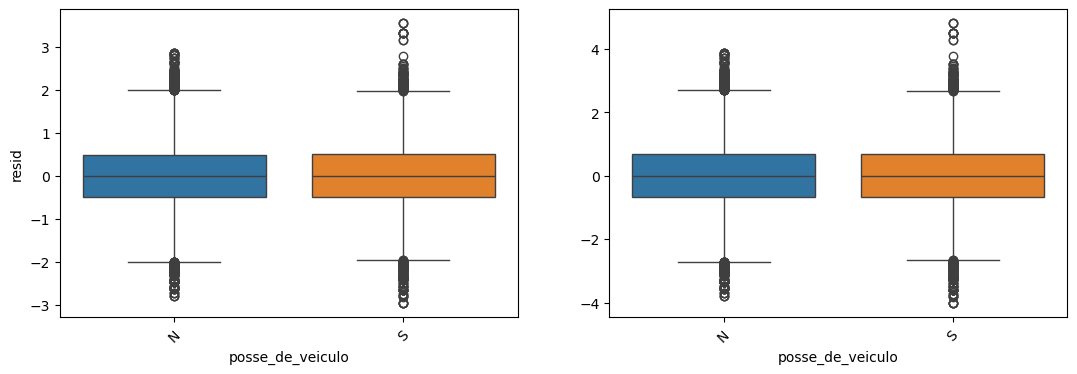

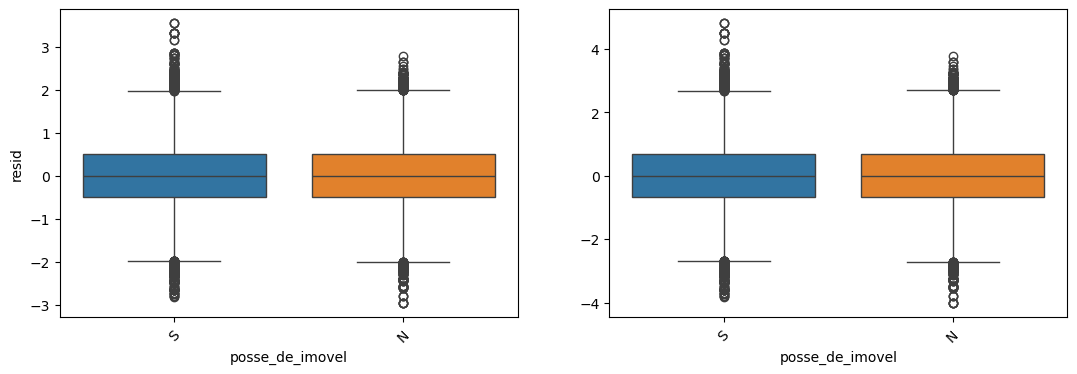

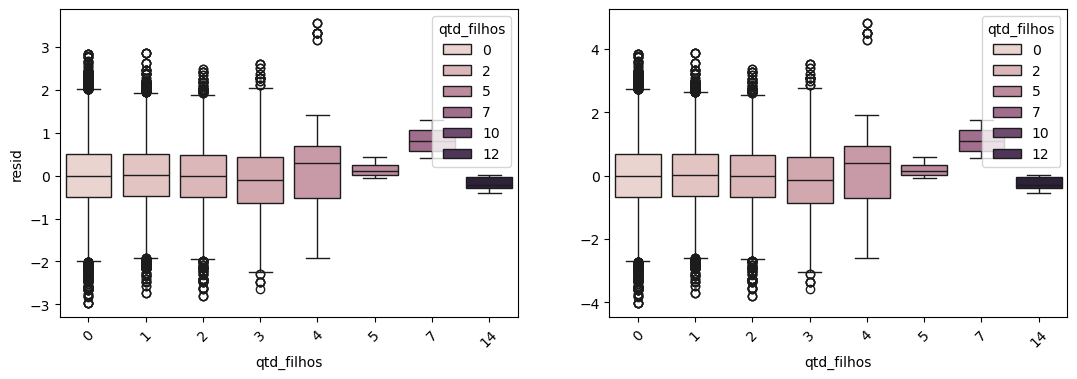

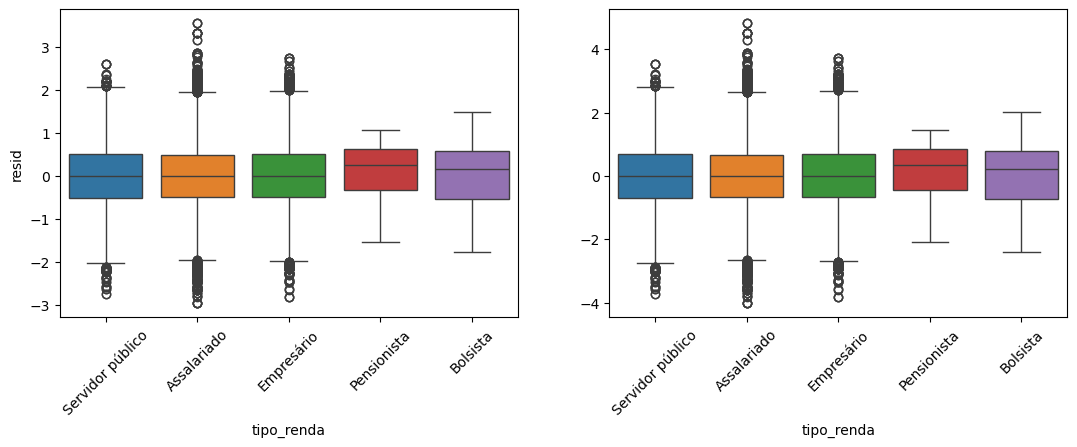

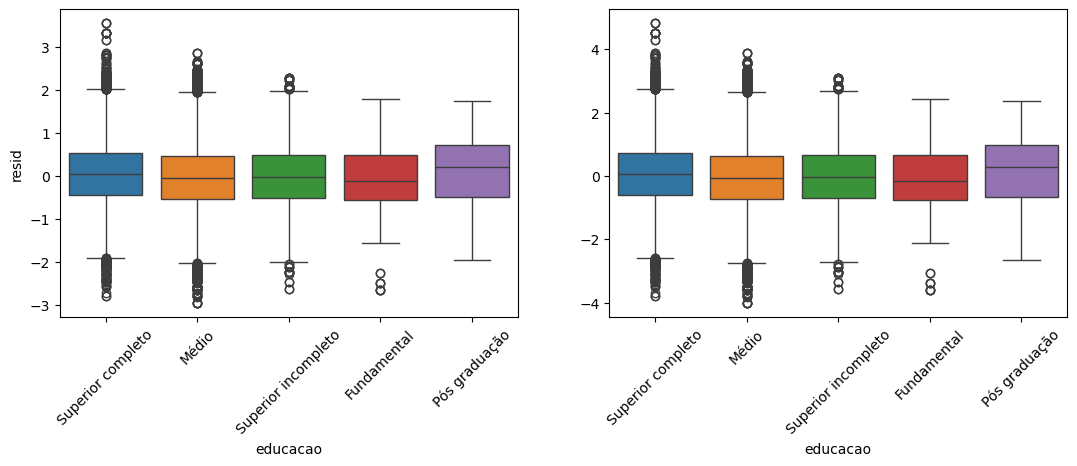

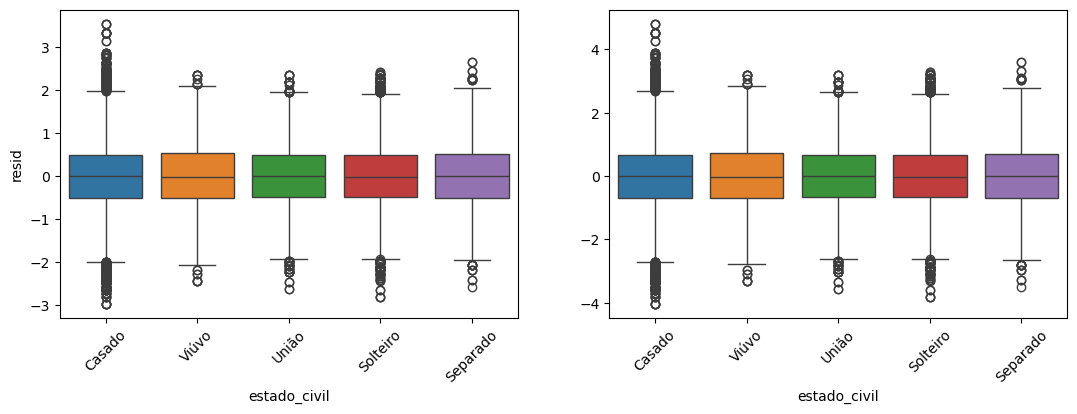

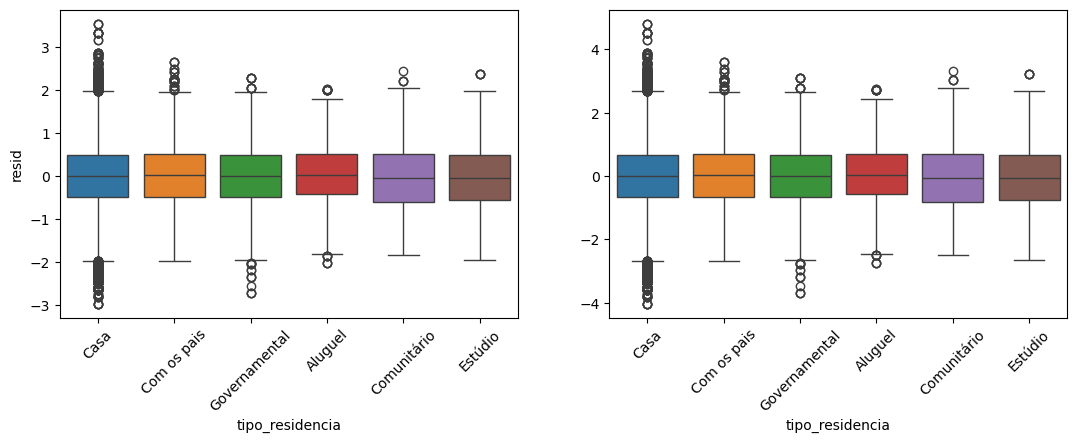

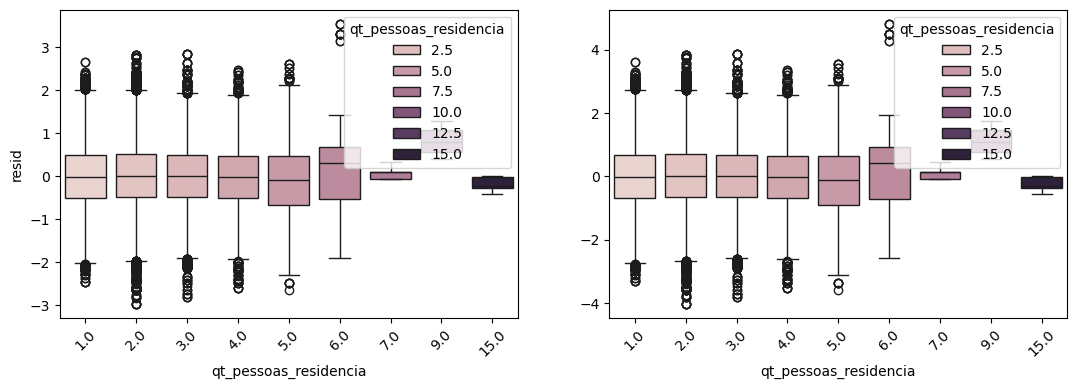

In [384]:
# Gráfico de resíduos e resíduos studentizados em função das variáveis (boxplot)

vars = [ 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 
       'qt_pessoas_residencia']

for var in vars:
    fig, ax = plt.subplots(1,2, figsize=[13, 4])
    
    sns.boxplot(data = df_test, x = var, y = reg_vif2.resid, hue = var, ax=ax[0])
    ax[0].set_ylabel('resid')
    ax[0].tick_params('x', rotation=45)
    
    sns.boxplot(data = df_test, x = var, y = st_res, hue = var, ax=ax[1])
    ax[1].tick_params('x', rotation=45)
    
    plt.show()  

A distribuição dos resíduos em função das variáveis está boa, mas também indica a existência de possíveis outliers. Aqui, novamente, vemos as variáveis com menor número de ocorrência apresentando um comportamento estranho, isso pode ser visto para `qtd_filhos` e `qt_pessoas_residencia` tanto para resíduos quanto para os resíduos studentizados.

#### Avaliando os pontos em relação aos resíduos de student

A princípio os resíduos devem se encontrar em -2 e +2 (valores acima de 2 são altos e acima de 3 muito altos), aproximadamente. Isso com base na distribuição t de student que é simétrica e tem "caudas" mais pesada que a distribuição normal, possibilitando intervalos mais amplos.

Para essa análise e com o objetivo de entender o impacto dos dados que estão além do intervalo comentado [-2, +2], iremos remover tais valores para avaliar o comportamento do modelo. Volto a destacar esses pontos não são necessariamente outliers, mas se destacam dos demais.

Vejamos como o modelo responde.


In [385]:
# tais pontos não são necessariamente outliers, mas são discrepantes em relação aos demais

df_off_points = df_test[(df_test['student_resid'] > 2) | (df_test['student_resid'] < -2)]
print(f'--> Tais pontos correspondem a {df_off_points.shape[0]/df_test.shape[0]:.2%} dos dados de teste.')
print(df_off_points.shape)
df_off_points.head()

--> Tais pontos correspondem a 4.52% dos dados de teste.
(5650, 14)


data_ref sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
600004 2016-01-01    F                S               N           0   
600012 2016-01-01    F                N               S           0   
600059 2016-01-01    F                N               S           0   
600105 2016-01-01    F                S               S           0   
600130 2016-01-01    F                S               S           0   

              tipo_renda           educacao estado_civil tipo_residencia  \
600004       Assalariado              Médio        Viúvo            Casa   
600012  Servidor público  Superior completo       Casado            Casa   
600059       Assalariado  Superior completo     Solteiro            Casa   
600105       Assalariado  Superior completo       Casado            Casa   
600130       Assalariado  Superior completo       Casado     Comunitário   

        idade  tempo_emprego  qt_pessoas_residencia      renda  student_resid  
600004     63       9.265753                    1.0   17633.03       2.231741  
600012     50       0.380822                    2.0   11498.74       2.802594  
600059     62      36.753425                    1.0  867641.27       2.409361  
600105     32       9.556164                    2.0   44193.65       3.167597  
600130     60       0.950685                    2.0    8708.48       2.570336

Note que cerca de $4.5$% dos dados de teste estão fora do intervalo, o que de certa forma é esperado uma vez que em uma distribuição normal aproximadamente $95$% dos dados se encontram dentro desse intervalo, $\pm 2$ do desvio padrão da média. Logo, os dados que selecionamos provavelmente se encontram no grupo dos $5$% mais extremos (são, de certo modo, candidatos a outlier).

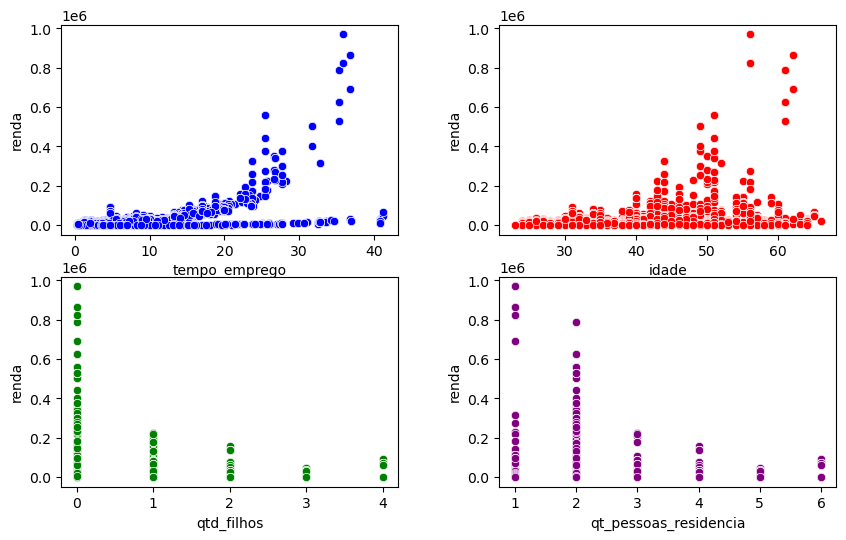

In [386]:
# Vejamos como tais pontos estão distribuidos em relação as variáveis numéricas
fig, ax = plt.subplots(2,2, figsize=[10,6])
sns.scatterplot(data=df_off_points, x = 'tempo_emprego', y = 'renda', color='blue', ax=ax[0,0])
sns.scatterplot(data=df_off_points, x = 'idade', y = 'renda', color='red', ax=ax[0,1])
sns.scatterplot(data=df_off_points, x = 'qtd_filhos', y = 'renda', color='green', ax=ax[1,0])
sns.scatterplot(data=df_off_points, x = 'qt_pessoas_residencia', y = 'renda', color='purple', ax=ax[1,1])
plt.subplots_adjust(wspace=.3)

In [388]:
# Removendo tais pontos da análise (não necessariamente são outliers)

# Adicionando o resíduo encontrado ao dataframe dummy
df_test_dummy.loc[:, 'student_resid'] = st_res
# Selecionando os dados de interesse
df_without_points = df_test_dummy[(df_test_dummy['student_resid'] < 2) & (df_test_dummy['student_resid'] > -2)]

# Regressão
reg_final = smf.ols("""np.log(renda) ~ tempo_emprego + sexo_M + posse_de_veiculo_S + 
                    posse_de_imovel_S + tipo_renda_Bolsista + tipo_renda_Empresário + 
                    tipo_renda_Servidor_público + estado_civil_Separado + 
                    tipo_residencia_Comunitário + tipo_residencia_Governamental""", 
                    data = df_without_points).fit()
reg_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                 2.132e+04
Date:                Thu, 12 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:24:53   Log-Likelihood:            -1.1777e+05
No. Observations:              119321   AIC:                         2.356e+05
Df Residuals:                  119310   BIC:                         2.357e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         6.8969      0.005   1431.505      0.000       6.887       6.906
tempo_emprego                     0.1308      0.000    450.969      0.000       0.130       0.131
sexo_M                            0.1307      0.004     31.083      0.000       0.123       0.139
posse_de_veiculo_S                0.0133      0.004      3.284      0.001       0.005       0.021
posse_de_imovel_S                 0.1918      0.004     48.285      0.000       0.184       0.200
tipo_renda_Bolsista              -0.1892      0.081     -2.328      0.020      -0.348      -0.030
tipo_renda_Empresário             0.1612      0.004     37.346      0.000       0.153       0.170
tipo_renda_Servidor_público       0.1323      0.006     20.790      0.000       0.120       0.145
estado_civil_Separado             0.0443      0.008      5.473      0.000       0.028       0.060
tipo_residencia_Comunitário      -0.1061      0.027     -3.987      0.000      -0.158      -0.054
tipo_residencia_Governamental     0.0330      0.011      3.058      0.002       0.012       0.054
==============================================================================
Omnibus:                     4363.331   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1938.763
Skew:                          -0.011   Prob(JB):                         0.00
Kurtosis:                       2.376   Cond. No.                         442.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Com as considerações estabelecidas o modelo de regressão teve um bom incremento no valor de R-quadrado, saindo de $0.583$ para $0.641$. Manteve bons coeficientes, bons P-values e também intervalos de confiança.

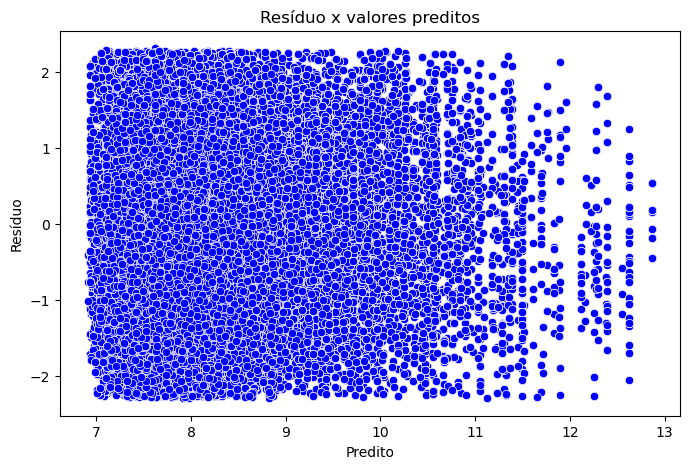

In [402]:
# Verificando a distribuição dos resíduos em função dos valores preditos
# A homocedasticidade 
fig, ax = plt.subplots(figsize=[8,5])

# obtendo resíduos studentizados
influence = reg_final.get_influence()
student_res = influence.resid_studentized_internal

sns.scatterplot(x = reg_final.predict(), y = student_res, color='blue', ax=ax)
ax.set_xlabel('Predito')
ax.set_ylabel('Resíduo')
ax.set_title('Resíduo x valores preditos');

Após as análises e alterações no modelo os dados apresentam uma boa homocedasticidade.

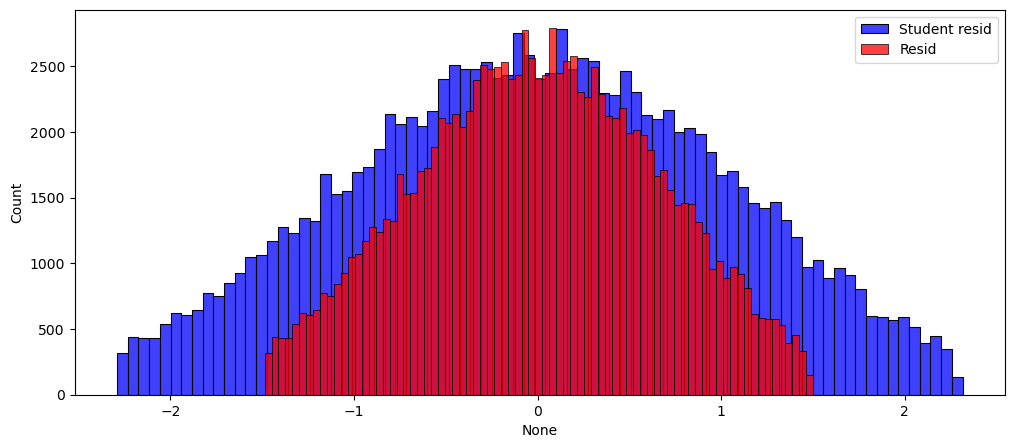

In [393]:
# A distribuição dos resíduos
influence = reg_final.get_influence()
student_res = influence.resid_studentized_internal

fig, ax = plt.subplots(figsize=[12,5])
sns.histplot(x = student_res, color='blue',  ax=ax, label='Student resid')
sns.histplot(x = reg_final.resid, color='red',  ax=ax, label='Resid')
ax.legend()
plt.show()

Agora temos a distribuição dos resíduos de Student se limitando a valores próximos de 2.

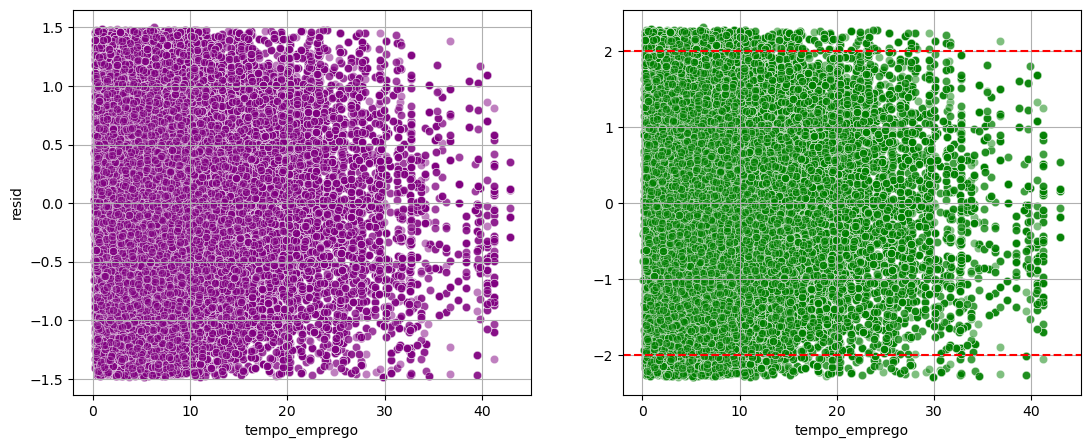

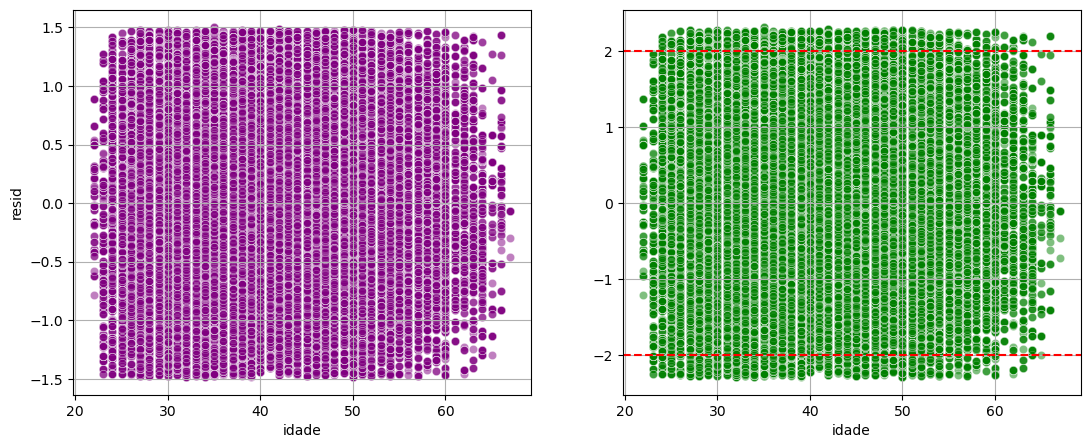

In [394]:
# Avaliando os pontos de influência e os valores previstos

influence = reg_final.get_influence()
student_res = influence.resid_studentized_internal

# Gráfico de resíduos e resíduos studentizados em função das variáveis (scatterplot)

vars = ['tempo_emprego', 'idade']

for var in vars:
    fig, ax = plt.subplots(1,2, figsize=[13, 5])
    
    sns.scatterplot(x=var, y=reg_final.resid, 
                    data=df_without_points, color='purple', 
                    alpha=.5, ax=ax[0])
    ax[0].set_ylabel('resid')
    ax[0].grid()
    sns.scatterplot(x=var, y=student_res, 
                    data=df_without_points, color='green', 
                    alpha=.5, ax=ax[1])
    ax[1].grid()
    ax[1].axhline(2, color='red', ls='--')
    ax[1].axhline(-2, color='red', ls='--')
    plt.show()

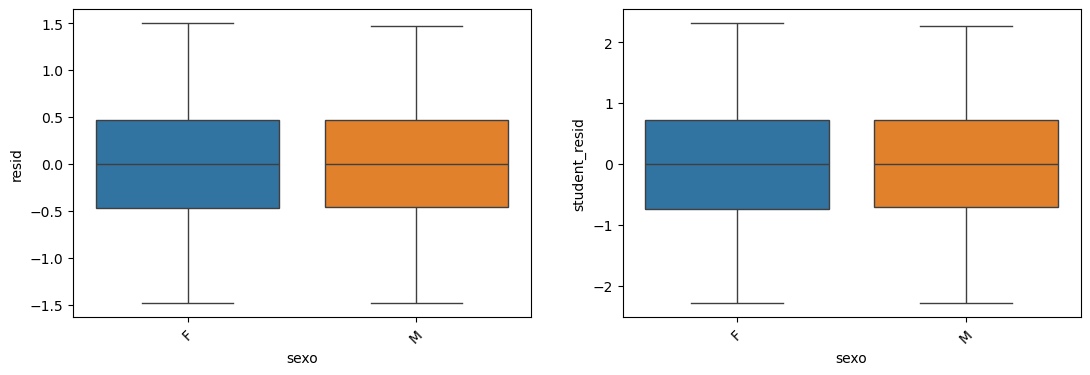

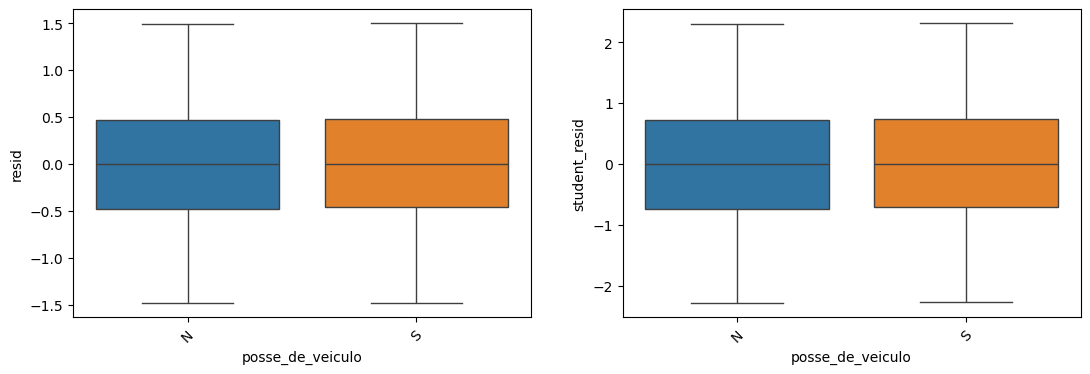

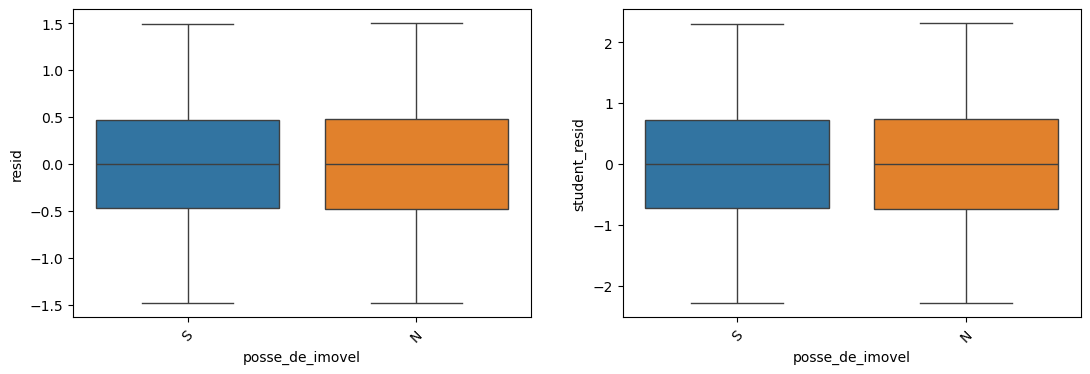

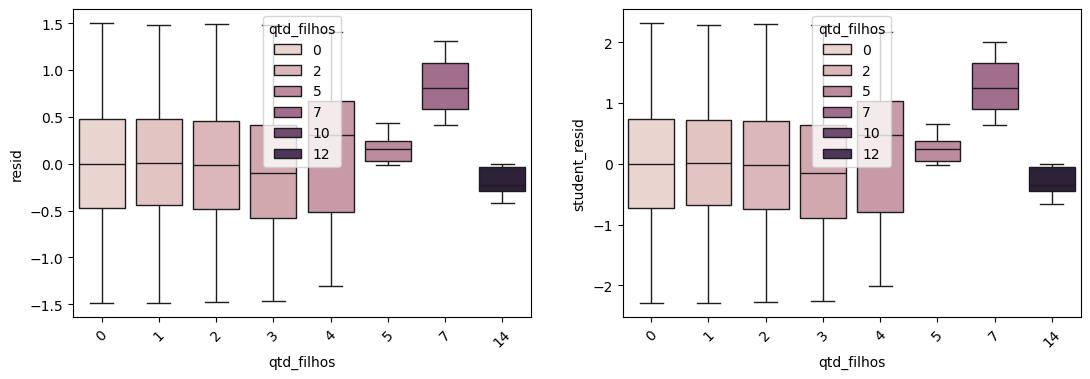

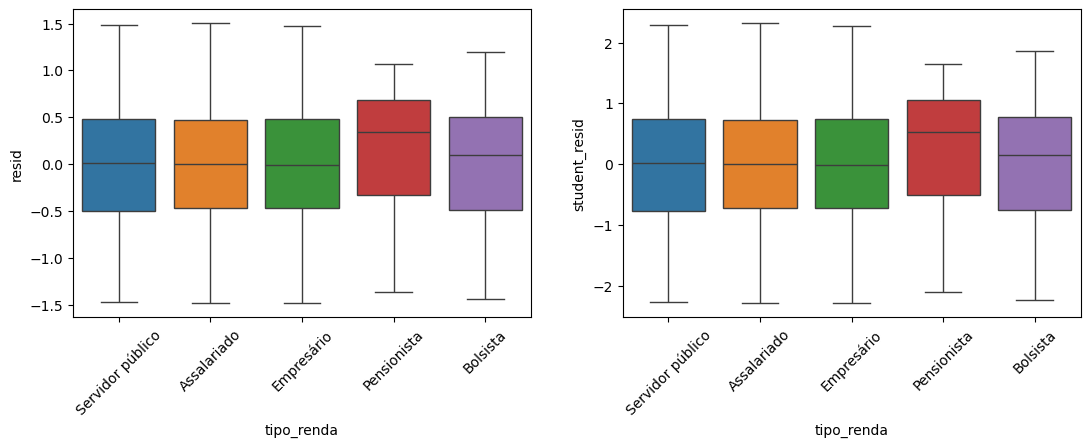

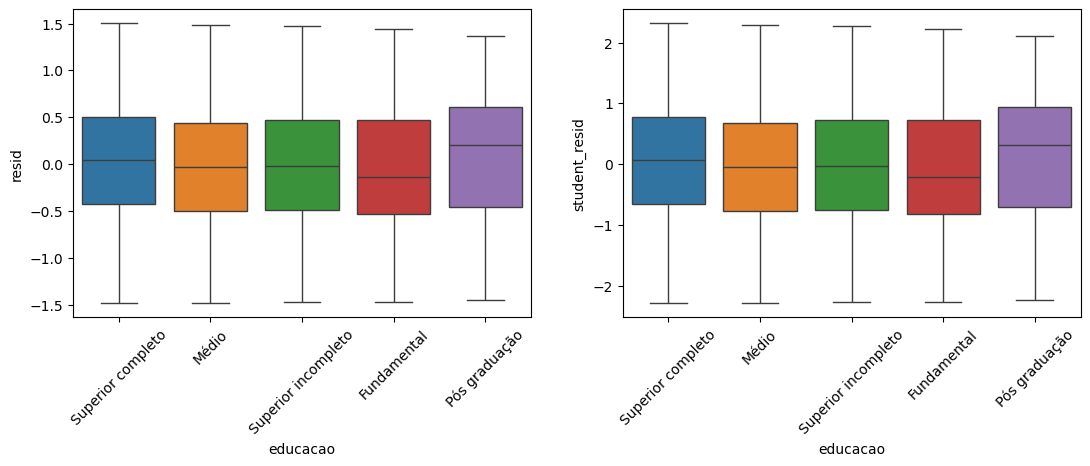

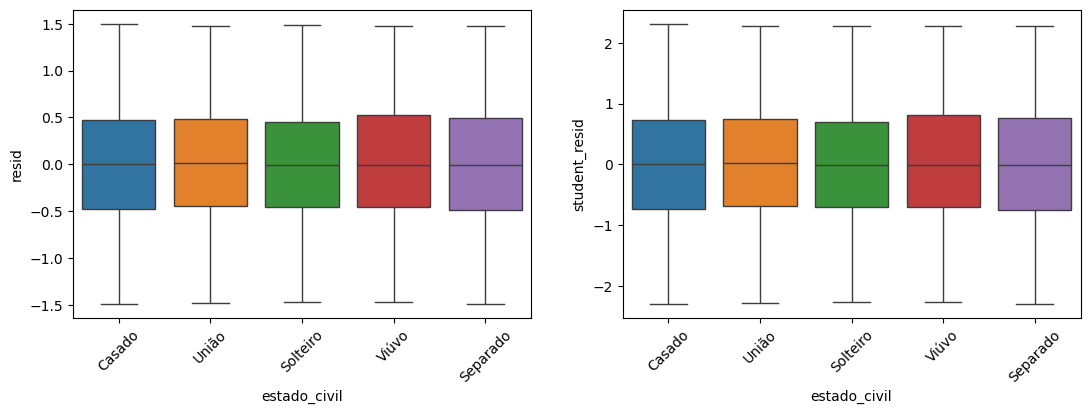

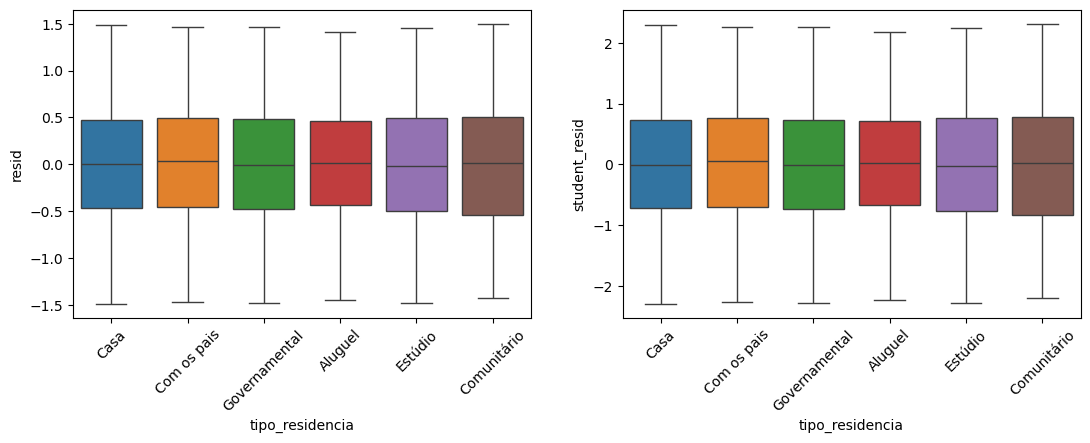

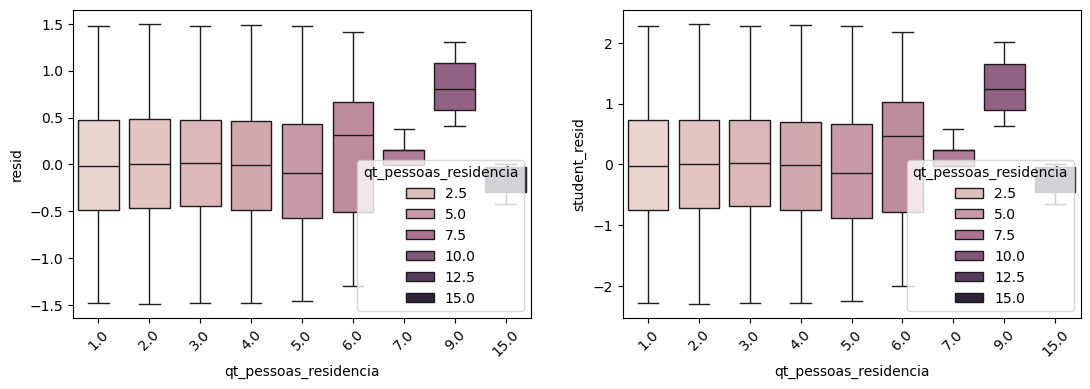

In [401]:
# Para as demais variáveis

vars = [ 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 
       'qt_pessoas_residencia']

df_test_points = df_test[(df_test.student_resid > -2) & (df_test.student_resid <2)]

for var in vars:
    fig, ax = plt.subplots(1,2, figsize=[13, 4])
    
    sns.boxplot(data = df_test_points, x = var, y = reg_final.resid, hue = var, ax=ax[0])
    ax[0].set_ylabel('resid')
    ax[0].tick_params('x', rotation=45)
    
    sns.boxplot(data = df_test_points, x = var, y = student_res, hue = var, ax=ax[1])
    ax[1].set_ylabel('student_resid')
    ax[1].tick_params('x', rotation=45)
    
    plt.show()  

Os resíduos e resíduos studentizados estão bem distribuídos, apresentando valores ruins nas variáveis com categorias pouco frequentes como já citado (`qtd_filhos` e `qt_pessoas_residencia`).

#### Insights

- O modelo final, após as considerações de VIF, análise de P-value, consideração dos resíduos de Student apresentou um bom valor de R-quadrado, uma baixa multicolinearidade e uma boa legibilidade de suas estatísticas. O valor de R-quadrado para o modelo final foi de ~$64$%.
- No processo de entendimento e treino uma porcentagem não muito grande dos pontos foi removida, mas vale destacar que esses podem ser pontos reais, porém destoam dos demais, o que os torna pouco representativos.